# 📚 Final Project — Introduction to Deep Learning
## Image Classification with Convolutional Neural Networks (CNNs)

---

### 🔍 Overview
Design, train, and analyze **convolutional neural networks (CNNs)** for an image classification problem of your choice (the same one selected in Exercise 1). You previously built a dataset (~1,000 images) and trained a classifier using **fastai**. In this project, you will implement and train your own network in **PyTorch** (without fastai).

> **Focus is not only on accuracy.** Emphasize architectural choices, optimization strategies, hyperparameter tuning, overfitting vs generalization, and explaining *why* things worked or didn’t.

---

### 🎯 Learning Goals
- Design and train CNN architectures for image classification  
- Experiment with optimization algorithms and hyperparameters  
- Apply batch normalization and regularization techniques  
- Use transfer learning effectively  
- Work with pretrained networks (e.g., ResNet50)  
- Analyze and communicate experimental results clearly  

---

### 🧭 Project Structure (Summary)
- **Part 1 — Training a CNN from Scratch**  
  Build models, compare architectures/optimizers/hyperparameters; add batch norm & regularization; analyze overfitting vs generalization.
- **Part 2 — Transfer Learning**  
  Pretrain on an external dataset (e.g., CIFAR-10), then fine-tune on your dataset; compare with training from scratch.
- **Part 3 — Transfer learning with a Pretrained Network (ResNet50)**  
  Adapt ResNet50, replace the final layer, experiment with freezing/unfreezing and fine-tuning.

---

### 📦 Deliverables
- **Code:** All notebooks & scripts, clear structure/documentation, hosted in your **GitHub repo** from Exercise 1.  
- **Presentation (PPT):** Problem & dataset, experiments & results, comparisons & conclusions, final reflection.

---

### 🧪 Evaluation Criteria
- Experimental rigor  
- Quality of analysis  
- Clarity of explanations  
- Thoughtfulness of conclusions  
- Code organization & reproducibility  

*Accuracy alone is **not** the main criterion.*

---

### 📜 Academic Integrity
You may use external resources for reference, but:
- All work must be your own  
- You must understand and explain every line of code you submit  

---

## 📎 Appendix — Detailed Instructions (Click to expand)

<details>
  <summary><strong>Part 1 — Training a CNN from Scratch</strong></summary>

  ### Step 1 — Architecture & Optimization
  1. Choose <strong>at least two different CNN architectures</strong> (e.g., shallow vs deeper CNN).
  2. Compare <strong>optimization algorithms</strong> such as Adam and SGD with momentum.
  3. Tune key hyperparameters: <em>learning rate, batch size, number of epochs</em>.

  **Document every experiment clearly.** Explain:  
  - Why you chose each architecture  
  - How hyperparameters affected training  
  - What worked vs what didn’t  

  ### Step 2 — Add Batch Normalization
  Modify your best-performing architecture by adding <strong>Batch Normalization</strong> layers. Analyze:  
  - Training stability  
  - Convergence speed  
  - Validation performance  

  *Compare results with and without batch normalization.*

  ### Step 3 — Add Regularization
  Add <strong>regularization techniques</strong>:
  - Dropout  
  - Weight decay (L2 regularization)  
  - Data augmentation  

  Analyze:
  - Overfitting vs generalization  
  - Training vs validation curves  

  *Explain which regularization methods helped and why.*

  > Note: Depending on your dataset size and problem complexity, accuracy in Part 1 may be limited—you may need more data.
</details>

<details>
  <summary><strong>Part 2 — Transfer Learning</strong></summary>

  ### Step 4 — Pretraining on an External Dataset
  1. Choose an external image dataset (e.g., CIFAR-10 or another public dataset).  
  2. Train your CNN architecture on this dataset (or a subset if it’s too large).  
  3. Adjust your architecture as needed.  
  4. Save the trained weights.  

  *Explain why this dataset is relevant and what features it may teach the model.*

  ### Step 5 — Fine-Tuning on Your Dataset
  1. Load the pretrained weights.  
  2. Fine-tune the network using your dataset.  
  3. Compare results with training from scratch.  

  Analyze:
  - Speed of convergence  
  - Final accuracy  
  - Generalization  

  **Notes:**
  1. You may need to adjust image sizes/shapes to match your network’s expected input.  
  2. Adjust the final classification layer to the number of classes in the target dataset.
</details>

<details>
  <summary><strong>Part 3 — Transfer learning with a Pretrained Network (ResNet50)</strong></summary>

  ### Step 6 — Adapting a Pretrained Model
  1. Load <strong>ResNet50 pretrained on ImageNet</strong>.  
  2. Replace the final classification layer to match your number of classes.  
  3. Freeze and unfreeze layers as needed.  

  *Explain your design choices.*

  ### Step 7 — Training & Fine-Tuning
  1. Fine-tune the modified ResNet50 on your dataset.  
  2. Experiment with: freezing vs unfreezing layers, learning rates, and data augmentation.  

  Compare:
  - Performance vs your custom CNN  
  - Training time  
  - Stability  
</details>

<details>
  <summary><strong>Results & Analysis</strong></summary>

  Include:
  - Training & validation curves  
  - Quantitative metrics (accuracy, loss)  
  - Qualitative observations  
  - Short conclusions  

  **Focus on reasoning, not just numbers.**
</details>

<details>
  <summary><strong>Final Reflection</strong></summary>

  Reflect on:
  - What architectural choices mattered most?  
  - Which optimization strategies worked best?  
  - When did transfer learning help?  
  - What would you do differently with more time or data?  
</details>

<details>
  <summary><strong>What to Submit</strong></summary>

  - <strong>Code:</strong> All notebooks & scripts, clear structure & documentation, hosted in your <strong>GitHub repo</strong> from Exercise 1.  
  - <strong>Presentation (PPT):</strong> Problem & dataset, each experiment, results & comparisons, considerations & conclusions, final reflection.  

  *Explain your reasoning after every experiment.*
</details>

# Part 1 — Training a CNN from Scratch

In [2]:
import torch
import torch.nn as nn
from fastai.optimizer import weight_decay
from torchvision import models
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, Subset
from torchmetrics.classification import MulticlassConfusionMatrix
import matplotlib.pyplot as plt
import numpy as np
import os



### Load data

In [3]:
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define transforms
base_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

aug_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [4]:
def get_loaders(data_root='./data', batch_size=32, train_split=0.8, use_augmentation=False):
    np.random.seed(42)
    # Verify data directory exists
    if not os.path.exists(data_root):
        raise FileNotFoundError(f"Data directory '{data_root}' not found!")

    # Create two separate dataset instances with different transforms
    train_dataset = datasets.ImageFolder(root=data_root, transform=aug_transforms if use_augmentation else base_transforms)
    val_dataset = datasets.ImageFolder(root=data_root, transform=base_transforms)

    # Get total size and calculate split
    total_size = len(train_dataset)
    train_size = int(train_split * total_size)

    # Create indices for splitting
    indices = np.random.permutation(total_size)
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    # Create subsets using the same indices for both datasets
    train_data = Subset(train_dataset, train_indices)
    val_data = Subset(val_dataset, val_indices)

    # Create DataLoaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

### Training setup

In [5]:
class CNNExperiment:
    def __init__(self, model, train_loader, val_loader, optimizer="Adam", momentum=0.9):
        self.device = torch.device("mps" if torch.cuda.is_available() else "cpu")
        print(f"Using {self.device} device")
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.momentum = momentum
        self.criterion = nn.CrossEntropyLoss()
        self.batch_size = train_loader.batch_size
        self.history = {'train_loss': [], 'val_acc': []}


    def train_epoch(self, optimizer):
        self.model.train()
        running_loss = 0.0
        for inputs, labels in self.train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)

            optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        return running_loss / len(self.train_loader)

    def evaluate(self):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return 100 * correct / total

    def run(self, epochs, lr=1e-4, weight_decay:float=0, momentum:float=0.9, save_model=False):
        best_acc = 0.0
        print(f"--------- start experiment with: epochs={epochs} | lr={lr} | batch_size={self.batch_size}---------")
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay) if self.optimizer == "Adam" else optim.SGD(self.model.parameters(), lr=lr, momentum=momentum)
        for epoch in range(epochs):
            loss = self.train_epoch(optimizer)
            acc = self.evaluate()
            if save_model and acc > best_acc:
                best_acc = acc
                torch.save(model.state_dict(), './models/best_cifar10_model.pth')
                print(f"New record! Model saved with accuracy: {best_acc}%")

            self.history['train_loss'].append(loss)
            self.history['val_acc'].append(acc)
            print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f}, Val Acc: {acc:.2f}%")



In [11]:
def plot_experiment_results(histories, titles):
    """
    histories: list of history dictionaries from CNNExperiment
    titles: list of strings describing each experiment
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    for history, title in zip(histories, titles):
        ax1.plot(history['train_loss'], label=f'{title} (Loss)')
        ax2.plot(history['val_acc'], label=f'{title} (Acc)')

    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    plt.show()

In [6]:
def plot_confusion_matrix(model, loader, device, num_classes=3, class_names=("Awake", "Fainted", "Sleeping")):
    metric = MulticlassConfusionMatrix(num_classes=num_classes).to(device)
    model.eval()

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            # Update the metric with the current batch
            metric.update(preds, labels)

    # Compute the final matrix and plot it
    fig, ax = metric.plot(labels=class_names)
    ax.set_title("Confusion Matrix")
    plt.show()

In [7]:
def get_top_bottom_losses(model, loader, device, n=9):
    model.eval()
    all_losses = []
    all_preds = []
    all_labels = []
    all_images = []

    # Use reduction='none' to get loss for each individual image
    criterion = torch.nn.CrossEntropyLoss(reduction='none')

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Calculate individual losses
            losses = criterion(outputs, labels)
            preds = torch.argmax(outputs, dim=1)

            # Store data (moving to CPU for plotting)
            all_losses.extend(losses.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # We store the images to plot them later
            # (Note: depending on memory, you might want to store only n images)
            all_images.extend(inputs.cpu())

    # Sort by loss descending
    # zip all lists and sort based on the loss value
    combined = sorted(zip(all_losses, all_preds, all_labels, all_images),
                      key=lambda x: x[0], reverse=True)

    return combined[:n], combined[-n:] # Return top n losses and bottom n losses

In [8]:
def plot_top_losses(top_losses):
    """
    Plots the images with highest losses.
    Format: Prediction / Actual / Loss
    """
    class_names = ['Awake', 'Fainted', 'Sleeping']
    n = len(top_losses)
    cols = 3
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(15, rows * 5))

    for i, (loss, pred, label, img) in enumerate(top_losses):
        ax = plt.subplot(rows, cols, i + 1)

        # Un-normalize image for display (assuming standard ImageNet normalization)
        img = img.permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        plt.imshow(img)
        title = f"Pred: {class_names[pred]}\nActual: {class_names[label]}\nLoss: {loss:.2f}"

        # Color: Red if wrong, Green if correct (but high loss anyway)
        color = 'red' if pred != label else 'green'
        ax.set_title(title, color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

## Step 1 - Architecture and optimization

### Shallow CNN

In [52]:
class ShallowCNN(nn.Module):
    def __init__(self, num_classes=3):
        torch.manual_seed(42)
        super(ShallowCNN, self).__init__()

        # Convolution layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 3x128x128 -> 16x64x64 after pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 16x64x64 -> 32x32x32 after pooling
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 32x32x32 -> 64x16x16 after pooling

        # Fully Connected Head
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)

        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


#### Experiment 1: LR fine-tuning
* We test three different lr in an exponential scale starting from 1e-3 down to 1e-5
* Our goal in this experiment was to find the highest lr which demonstrates steady smooth learning curve in the training loss and in corresponds at the accuracy graph.
* It was first tested in the same batch size of 32 so we take in consider the noizy batches in relation to the lr high.

Using cpu device
--------- start experiment with: epochs=20 | lr=0.001 | batch_size=32---------
Epoch 1/20 - Loss: 0.9977, Val Acc: 59.26%
Epoch 2/20 - Loss: 0.7647, Val Acc: 66.67%
Epoch 3/20 - Loss: 0.6108, Val Acc: 65.74%
Epoch 4/20 - Loss: 0.5398, Val Acc: 70.37%
Epoch 5/20 - Loss: 0.3566, Val Acc: 70.37%
Epoch 6/20 - Loss: 0.2833, Val Acc: 69.44%
Epoch 7/20 - Loss: 0.2202, Val Acc: 69.44%
Epoch 8/20 - Loss: 0.1722, Val Acc: 59.26%
Epoch 9/20 - Loss: 0.1104, Val Acc: 68.52%
Epoch 10/20 - Loss: 0.0576, Val Acc: 70.37%
Epoch 11/20 - Loss: 0.0246, Val Acc: 70.37%
Epoch 12/20 - Loss: 0.0075, Val Acc: 71.30%
Epoch 13/20 - Loss: 0.0055, Val Acc: 68.52%
Epoch 14/20 - Loss: 0.0044, Val Acc: 69.44%
Epoch 15/20 - Loss: 0.0016, Val Acc: 70.37%
Epoch 16/20 - Loss: 0.0012, Val Acc: 70.37%
Epoch 17/20 - Loss: 0.0008, Val Acc: 70.37%
Epoch 18/20 - Loss: 0.0007, Val Acc: 70.37%
Epoch 19/20 - Loss: 0.0005, Val Acc: 70.37%
Epoch 20/20 - Loss: 0.0005, Val Acc: 70.37%
Using cpu device
--------- start 

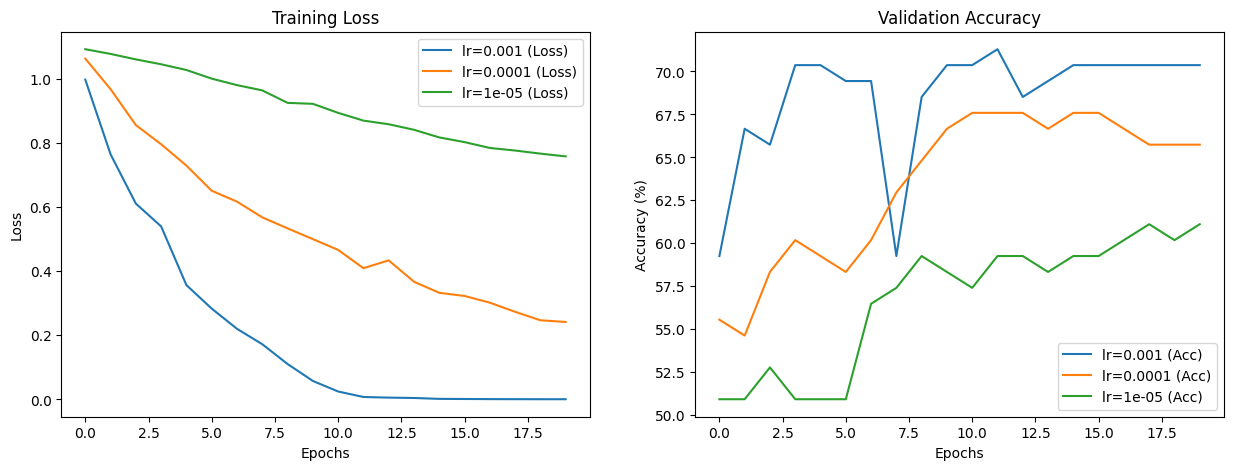

In [55]:
train_loader, val_loader = get_loaders(batch_size=32)
LRs = [1e-3, 1e-4, 1e-5]
experiments = []

for lr in LRs:
    model = ShallowCNN()
    experiment = CNNExperiment(model, train_loader, val_loader)
    experiment.run(epochs=20, lr=lr)
    experiments.append(experiment)

plot_experiment_results([exp.history for exp in experiments], [f"lr={lr}" for lr in LRs])


### Experiment 2: Batch size fine tuning
* After choosing LR = 1e-3, our goal in this experiment was to find the best batch size which gives the fastest and smoothest convergence in training loss while preserving smooth incline in validation accuracy.
* Our conclusion is that batch size of 32 demonstrate the highes accuracy in the earliest epochs.
* Notice our train dataset is in size of roughly ~430 images so probably batch size 16 was too noisy and therefor keep oscillate around 67% accuracy and batch size 64 was too big for validation set which contains ~110 images.

Using cpu device
--------- start experiment with: epochs=30 | lr=0.001 | batch_size=16---------
Epoch 1/30 - Loss: 0.9764, Val Acc: 62.96%
Epoch 2/30 - Loss: 0.6877, Val Acc: 66.67%
Epoch 3/30 - Loss: 0.5365, Val Acc: 64.81%
Epoch 4/30 - Loss: 0.4010, Val Acc: 71.30%
Epoch 5/30 - Loss: 0.2416, Val Acc: 66.67%
Epoch 6/30 - Loss: 0.1372, Val Acc: 69.44%
Epoch 7/30 - Loss: 0.0745, Val Acc: 71.30%
Epoch 8/30 - Loss: 0.0296, Val Acc: 69.44%
Epoch 9/30 - Loss: 0.0119, Val Acc: 70.37%
Epoch 10/30 - Loss: 0.0508, Val Acc: 67.59%
Epoch 11/30 - Loss: 0.0507, Val Acc: 66.67%
Epoch 12/30 - Loss: 0.0195, Val Acc: 68.52%
Epoch 13/30 - Loss: 0.0140, Val Acc: 65.74%
Epoch 14/30 - Loss: 0.0402, Val Acc: 71.30%
Epoch 15/30 - Loss: 0.0046, Val Acc: 70.37%
Epoch 16/30 - Loss: 0.0011, Val Acc: 68.52%
Epoch 17/30 - Loss: 0.0006, Val Acc: 68.52%
Epoch 18/30 - Loss: 0.0004, Val Acc: 68.52%
Epoch 19/30 - Loss: 0.0003, Val Acc: 67.59%
Epoch 20/30 - Loss: 0.0003, Val Acc: 67.59%
Epoch 21/30 - Loss: 0.0002, Val A

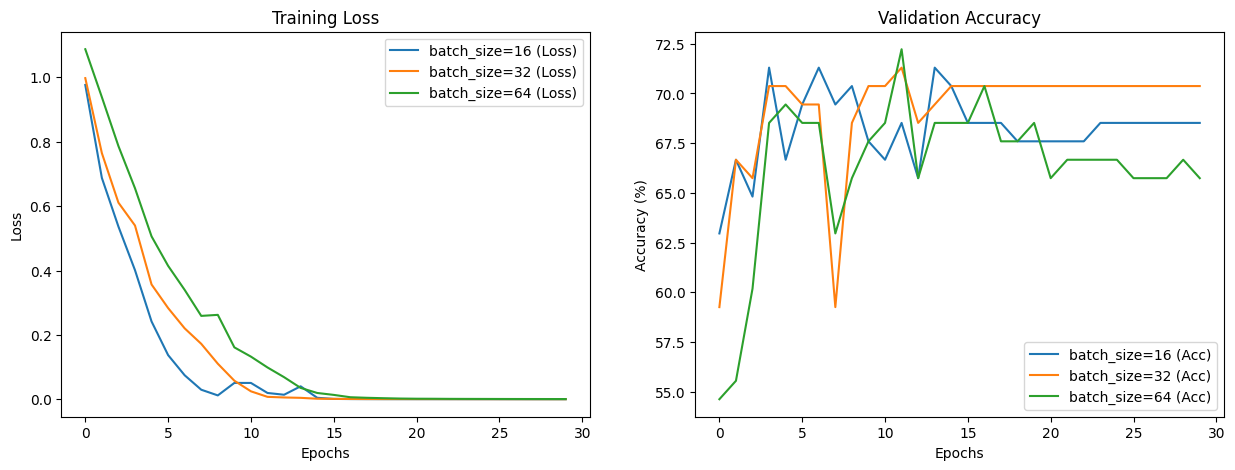

In [69]:
batch_sizes = [16, 32, 64]
experiments = []

for size in batch_sizes:
    train_loader, val_loader = get_loaders(batch_size=size)
    model = ShallowCNN()
    experiment = CNNExperiment(model, train_loader, val_loader)
    experiment.run(epochs=30, lr=1e-3)
    experiments.append(experiment)

plot_experiment_results([exp.history for exp in experiments], [f"batch_size={size}" for size in batch_sizes])

### Experiment 3: Optimizer fine tuning (Adam vs. SGD with momentum)

* Adam demonstrate higher speed convergence and a consistent higher accuracy than the sgd.

Using cpu device
--------- start experiment with: epochs=20 | lr=0.001 | batch_size=32---------
Epoch 1/20 - Loss: 0.9977, Val Acc: 59.26%
Epoch 2/20 - Loss: 0.7647, Val Acc: 66.67%
Epoch 3/20 - Loss: 0.6108, Val Acc: 65.74%
Epoch 4/20 - Loss: 0.5398, Val Acc: 70.37%
Epoch 5/20 - Loss: 0.3566, Val Acc: 70.37%
Epoch 6/20 - Loss: 0.2833, Val Acc: 69.44%
Epoch 7/20 - Loss: 0.2202, Val Acc: 69.44%
Epoch 8/20 - Loss: 0.1722, Val Acc: 59.26%
Epoch 9/20 - Loss: 0.1104, Val Acc: 68.52%
Epoch 10/20 - Loss: 0.0576, Val Acc: 70.37%
Epoch 11/20 - Loss: 0.0246, Val Acc: 70.37%
Epoch 12/20 - Loss: 0.0075, Val Acc: 71.30%
Epoch 13/20 - Loss: 0.0055, Val Acc: 68.52%
Epoch 14/20 - Loss: 0.0044, Val Acc: 69.44%
Epoch 15/20 - Loss: 0.0016, Val Acc: 70.37%
Epoch 16/20 - Loss: 0.0012, Val Acc: 70.37%
Epoch 17/20 - Loss: 0.0008, Val Acc: 70.37%
Epoch 18/20 - Loss: 0.0007, Val Acc: 70.37%
Epoch 19/20 - Loss: 0.0005, Val Acc: 70.37%
Epoch 20/20 - Loss: 0.0005, Val Acc: 70.37%
Using cpu device
--------- start 

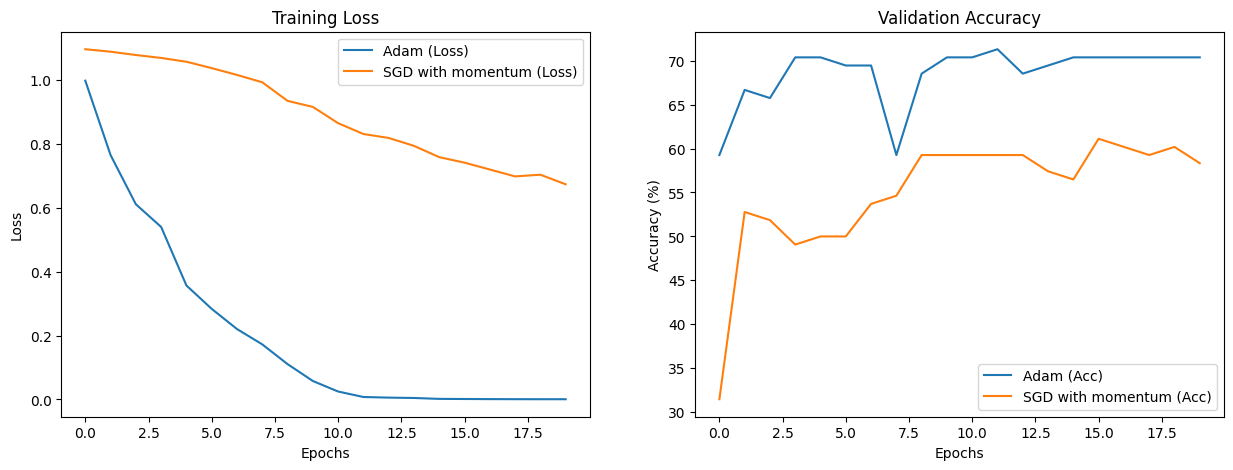

In [59]:
train_loader, val_loader = get_loaders()
experiments = []

model = ShallowCNN()
exp_with_adam = CNNExperiment(model, train_loader, val_loader)
exp_with_adam.run(epochs=20, lr=1e-3)
experiments.append(exp_with_adam)

model = ShallowCNN()
exp_with_sgd_momentum = CNNExperiment(model, train_loader, val_loader, optimizer="SGD", momentum=0.9)
exp_with_sgd_momentum.run(epochs=20, lr=1e-3)  # giving sgd a higher lr to move at a higher speed to fight Adam's speed.

plot_experiment_results([exp_with_adam.history, exp_with_sgd_momentum.history], [f"Adam", "SGD with momentum" ])

## Deep CNN

In [62]:
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define transforms
base_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

aug_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [64]:
import torch.nn.functional as F

class DeepCNN(nn.Module):
    def __init__(self, num_classes=3):
        torch.manual_seed(42)
        super(DeepCNN, self).__init__()

        # Convolutions layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 3x256x256 -> 32x128x128 after pooling
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 32x128x128 -> 64x64x64 after pooling
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 64x64x64 -> 128x32x32 after pooling
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # 128x32x32 -> 256x16x16 after pooling
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)  # 256x16x16 -> 512x8x8 after pooling
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)  # 512x8x8 -> 1024x4x4 after pooling

        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected head
        self.fc1 = nn.Linear(1024 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))

        x = x.view(x.size(0), -1) # Flatten

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

### Experiment 1: LR fine tuning
* We test three different lr in an exponential scale starting from 1e-3.
* Are goal in this level was to find highest LR that makes the training loss go down quickly without exploding.
* Compared to the ShallowCNN, the DeepCNN were more sensitive and converge slower so we gave it more epoches to learn.
* We chose to move on with lr=1e-3 as it converge fastest and smoothest.

Using cpu device
--------- start experiment with: epochs=30 | lr=0.001 | batch_size=32---------
Epoch 1/30 - Loss: 1.0785, Val Acc: 46.30%
Epoch 2/30 - Loss: 1.0049, Val Acc: 43.52%
Epoch 3/30 - Loss: 1.0776, Val Acc: 52.78%
Epoch 4/30 - Loss: 0.8879, Val Acc: 53.70%
Epoch 5/30 - Loss: 0.8267, Val Acc: 58.33%
Epoch 6/30 - Loss: 0.7789, Val Acc: 62.96%
Epoch 7/30 - Loss: 0.7281, Val Acc: 60.19%
Epoch 8/30 - Loss: 0.6811, Val Acc: 68.52%
Epoch 9/30 - Loss: 0.6185, Val Acc: 69.44%
Epoch 10/30 - Loss: 0.5876, Val Acc: 70.37%
Epoch 11/30 - Loss: 0.4725, Val Acc: 71.30%
Epoch 12/30 - Loss: 0.4355, Val Acc: 71.30%
Epoch 13/30 - Loss: 0.4001, Val Acc: 73.15%
Epoch 14/30 - Loss: 0.3601, Val Acc: 68.52%
Epoch 15/30 - Loss: 0.2698, Val Acc: 72.22%
Epoch 16/30 - Loss: 0.2218, Val Acc: 75.93%
Epoch 17/30 - Loss: 0.1668, Val Acc: 75.00%
Epoch 18/30 - Loss: 0.1582, Val Acc: 75.00%
Epoch 19/30 - Loss: 0.1394, Val Acc: 74.07%
Epoch 20/30 - Loss: 0.0692, Val Acc: 75.00%
Epoch 21/30 - Loss: 0.0557, Val A

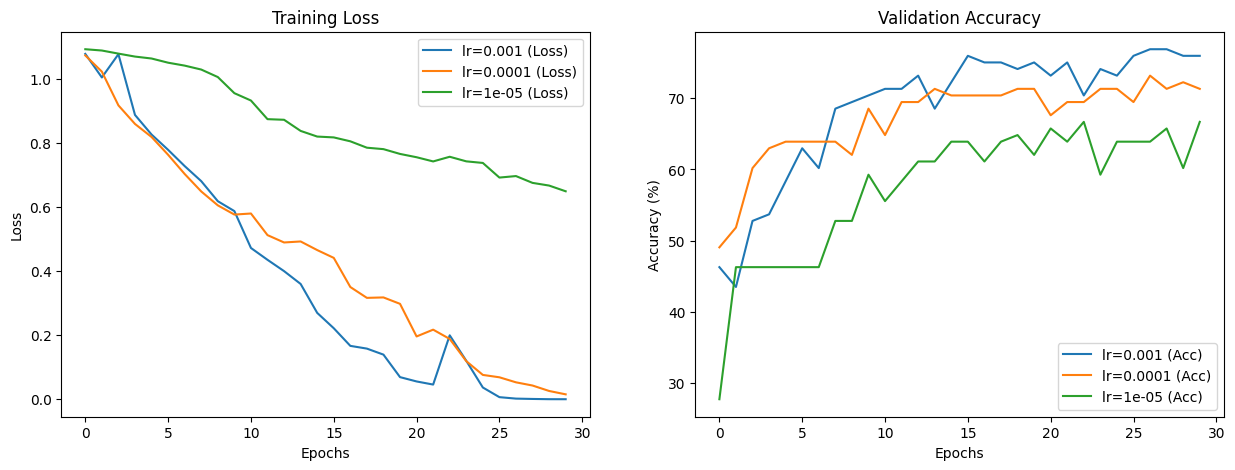

In [65]:
train_loader, val_loader = get_loaders()
LRs = [1e-3, 1e-4, 1e-5]
experiments = []

for lr in LRs:
    model = DeepCNN()
    experiment = CNNExperiment(model, train_loader, val_loader)
    experiment.run(epochs=30, lr=lr)
    experiments.append(experiment)

plot_experiment_results([exp.history for exp in experiments], [f"lr={lr}" for lr in LRs])

### Experiment 2: batch size fine-tuning
* After moving with LR = 1e-3, we want to optimize the batch size for it.
* Also, when we fine-tuned the ShallowNet, we realized that testing batch size if 64 is too high for our small dataset so we omitted it in this experiment.


Using cpu device
--------- start experiment with: epochs=30 | lr=0.001 | batch_size=16---------
Epoch 1/30 - Loss: 1.0619, Val Acc: 51.85%
Epoch 2/30 - Loss: 0.9238, Val Acc: 53.70%
Epoch 3/30 - Loss: 0.8792, Val Acc: 62.04%
Epoch 4/30 - Loss: 0.8280, Val Acc: 61.11%
Epoch 5/30 - Loss: 0.7947, Val Acc: 64.81%
Epoch 6/30 - Loss: 0.6843, Val Acc: 70.37%
Epoch 7/30 - Loss: 0.6028, Val Acc: 66.67%
Epoch 8/30 - Loss: 0.4950, Val Acc: 70.37%
Epoch 9/30 - Loss: 0.4321, Val Acc: 71.30%
Epoch 10/30 - Loss: 0.3917, Val Acc: 69.44%
Epoch 11/30 - Loss: 0.3572, Val Acc: 72.22%
Epoch 12/30 - Loss: 0.1995, Val Acc: 74.07%
Epoch 13/30 - Loss: 0.1787, Val Acc: 74.07%
Epoch 14/30 - Loss: 0.2690, Val Acc: 74.07%
Epoch 15/30 - Loss: 0.1099, Val Acc: 74.07%
Epoch 16/30 - Loss: 0.0911, Val Acc: 71.30%
Epoch 17/30 - Loss: 0.1081, Val Acc: 72.22%
Epoch 18/30 - Loss: 0.1540, Val Acc: 69.44%
Epoch 19/30 - Loss: 0.0609, Val Acc: 73.15%
Epoch 20/30 - Loss: 0.0423, Val Acc: 71.30%
Epoch 21/30 - Loss: 0.0918, Val A

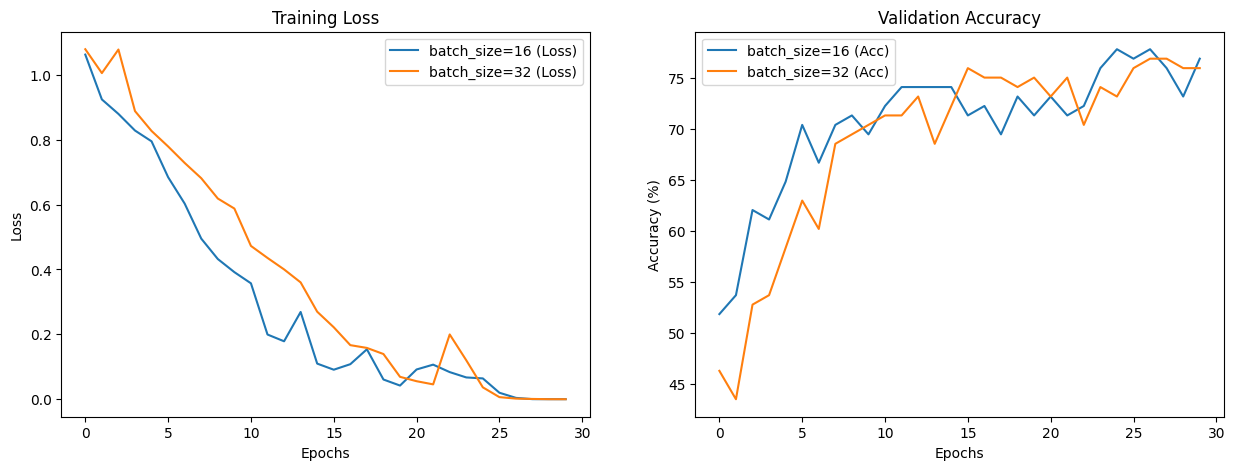

In [66]:
batch_sizes = [16, 32]
experiments = []

for size in batch_sizes:
    train_loader, val_loader = get_loaders(batch_size=size)
    model = DeepCNN()
    experiment = CNNExperiment(model, train_loader, val_loader)
    experiment.run(epochs=30, lr=1e-3)
    experiments.append(experiment)

plot_experiment_results([exp.history for exp in experiments], [f"batch_size={size}" for size in batch_sizes])

## step 1 - Conclusions:
* Why we chose each architecture:
    * We wanted to compare a shallow CNN with lower image resolution (128x128) and only 3 convolution layers with a deep CNN with a high resolution (256x256) contains 6 convolution layers.
    * Originally, we hypothesized that deep networks with high resolution images will have more details to learn and it will leverage the network sensitivity to classify between delicate classes like sleeping fainting.
    * After we tested both networks, we got similar training losses in much shorter training time with the shallow network. Despite having 1024 filters and high resolution input, the deep CNN didn't performed better. The 6-layer depth made backpropagation inefficient (vanishing gradients), and the high resolution added noise that the un-normalized network couldn't filter out efficiently.
    * The shallow CNN, with only 64 filters, proved that for small datasets, "keeping it simple" (lower resolution, fewer layers) often outperforms "going big" in the absence of advanced regularization.

* How hyperparameters effect training:
    * As we lowered the lr, training time got slower and required more epoches to demonstrate similar accuracies as 1e-3.
    * Because our dataset is relatively small compare to public datasets, we couldn't use high batch sizes in training (up to 64).
    * Validation set consist only ~110 images so we found that batch size 32 balanced between training speed and noize.
    * As result of the no-normalization policy in step 1, we think that the extra noise which come with smaller batch size might add an implicit regularization to the model.


Based on these experiments, we will proceed with the Shallow CNN trained on 128x128 images using Adam (lr=0.001, Batch Size=32).

## Step 2: applying batch normalization

In [71]:
class BnShallowCNN(nn.Module):
    def __init__(self, num_classes=3):
        torch.manual_seed(42)
        super(BnShallowCNN, self).__init__()

        # Convolution layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 3x128x128 -> 16x64x64 after pooling
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 16x64x64 -> 32x32x32 after pooling
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 32x32x32 -> 64x16x16 after pooling
        self.bn3 = nn.BatchNorm2d(64)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)

        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### experiment 1:  with vs without batch normalization

* Batch Normalization effectively prevented overfitting and improved generalization. The model without BN perfectly memorized the training set (near-zero loss) but stalled at 70.37% validation accuracy.
* In contrast, the BN model maintained a higher training loss—proving it avoided rote memorization—and achieved a superior validation accuracy of 74.07%.
* This demonstrates that the regularization forced the network to learn more robust, transferable features rather than specific pixel patterns.

Using cpu device
--------- start experiment with: epochs=20 | lr=0.001 | batch_size=32---------
Epoch 1/20 - Loss: 3.5975, Val Acc: 58.33%
Epoch 2/20 - Loss: 1.1975, Val Acc: 62.04%
Epoch 3/20 - Loss: 0.6991, Val Acc: 68.52%
Epoch 4/20 - Loss: 0.5244, Val Acc: 66.67%
Epoch 5/20 - Loss: 0.4427, Val Acc: 69.44%
Epoch 6/20 - Loss: 0.3419, Val Acc: 73.15%
Epoch 7/20 - Loss: 0.3045, Val Acc: 66.67%
Epoch 8/20 - Loss: 0.2692, Val Acc: 65.74%
Epoch 9/20 - Loss: 0.2241, Val Acc: 66.67%
Epoch 10/20 - Loss: 0.1760, Val Acc: 70.37%
Epoch 11/20 - Loss: 0.1386, Val Acc: 69.44%
Epoch 12/20 - Loss: 0.1047, Val Acc: 71.30%
Epoch 13/20 - Loss: 0.0933, Val Acc: 73.15%
Epoch 14/20 - Loss: 0.0802, Val Acc: 71.30%
Epoch 15/20 - Loss: 0.0592, Val Acc: 71.30%
Epoch 16/20 - Loss: 0.0467, Val Acc: 72.22%
Epoch 17/20 - Loss: 0.0360, Val Acc: 74.07%
Epoch 18/20 - Loss: 0.0302, Val Acc: 69.44%
Epoch 19/20 - Loss: 0.0315, Val Acc: 73.15%
Epoch 20/20 - Loss: 0.0317, Val Acc: 70.37%
Using cpu device
--------- start 

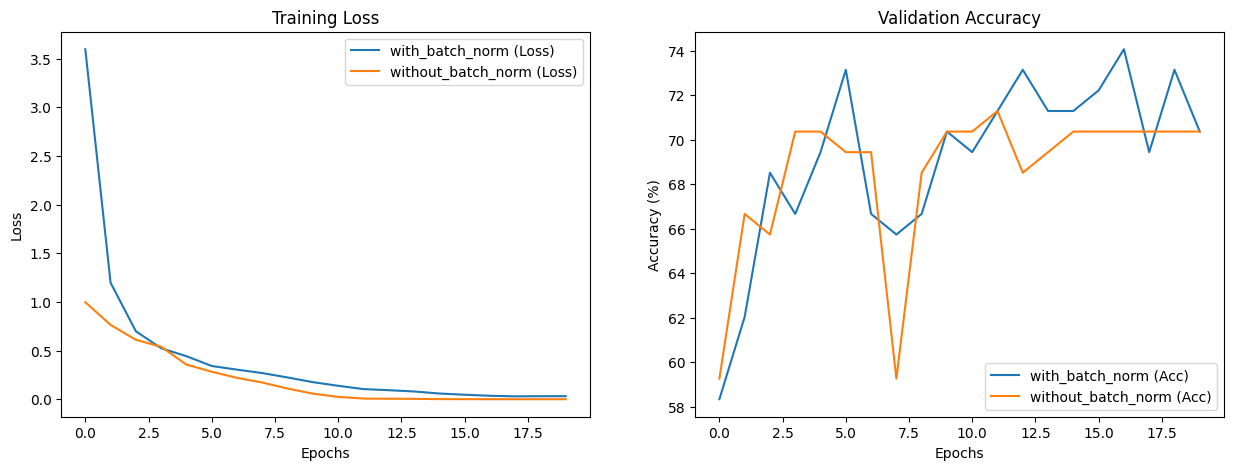

In [73]:
train_loader, val_loader = get_loaders(use_augmentation=False)

model = BnShallowCNN()
with_batch_norm_exp = CNNExperiment(model, train_loader, val_loader)
with_batch_norm_exp.run(epochs=20, lr=1e-3)

model = ShallowCNN()
without_batch_norm_exp = CNNExperiment(model, train_loader, val_loader)
without_batch_norm_exp.run(epochs=20, lr=1e-3)

plot_experiment_results([with_batch_norm_exp.history, without_batch_norm_exp.history], ["with_batch_norm", "without_batch_norm"])

## Step 3: Apply Regularization

In [9]:
class RegularizedShallowCNN(nn.Module):
    def __init__(self, num_classes=3, dropout_rate=0.2):
        torch.manual_seed(42)
        super(RegularizedShallowCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)

        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Experiment 1: with vs without Data Augmentation

The experiment confirms that Data Augmentation serves as a critical regularizer that enhances generalization.

* The model without augmentation succumbed to overfitting, evidenced by a near-zero training loss (0.03) but a lower validation peak.
* In contrast, the augmented model maintained a higher training loss (0.29), indicating it was forced to learn invariant features (shapes/textures) rather than memorizing static pixels.
* This robustness translated into better performance on unseen data, with the augmented model achieving the highest validation accuracy of **75.00%** (vs. **74.07%** without).

Using cpu device
--------- start experiment with: epochs=20 | lr=0.001 | batch_size=32---------
Epoch 1/20 - Loss: 2.7181, Val Acc: 53.70%
Epoch 2/20 - Loss: 0.9496, Val Acc: 54.63%
Epoch 3/20 - Loss: 0.7854, Val Acc: 58.33%
Epoch 4/20 - Loss: 0.7421, Val Acc: 67.59%
Epoch 5/20 - Loss: 0.6352, Val Acc: 67.59%
Epoch 6/20 - Loss: 0.6258, Val Acc: 71.30%
Epoch 7/20 - Loss: 0.5885, Val Acc: 66.67%
Epoch 8/20 - Loss: 0.5303, Val Acc: 67.59%
Epoch 9/20 - Loss: 0.4961, Val Acc: 69.44%
Epoch 10/20 - Loss: 0.4859, Val Acc: 70.37%
Epoch 11/20 - Loss: 0.4441, Val Acc: 70.37%
Epoch 12/20 - Loss: 0.4069, Val Acc: 74.07%
Epoch 13/20 - Loss: 0.3746, Val Acc: 72.22%
Epoch 14/20 - Loss: 0.3695, Val Acc: 66.67%
Epoch 15/20 - Loss: 0.3142, Val Acc: 73.15%
Epoch 16/20 - Loss: 0.3538, Val Acc: 59.26%
Epoch 17/20 - Loss: 0.3879, Val Acc: 68.52%
Epoch 18/20 - Loss: 0.2854, Val Acc: 67.59%
Epoch 19/20 - Loss: 0.2615, Val Acc: 75.00%
Epoch 20/20 - Loss: 0.2869, Val Acc: 74.07%
Using cpu device
--------- start 

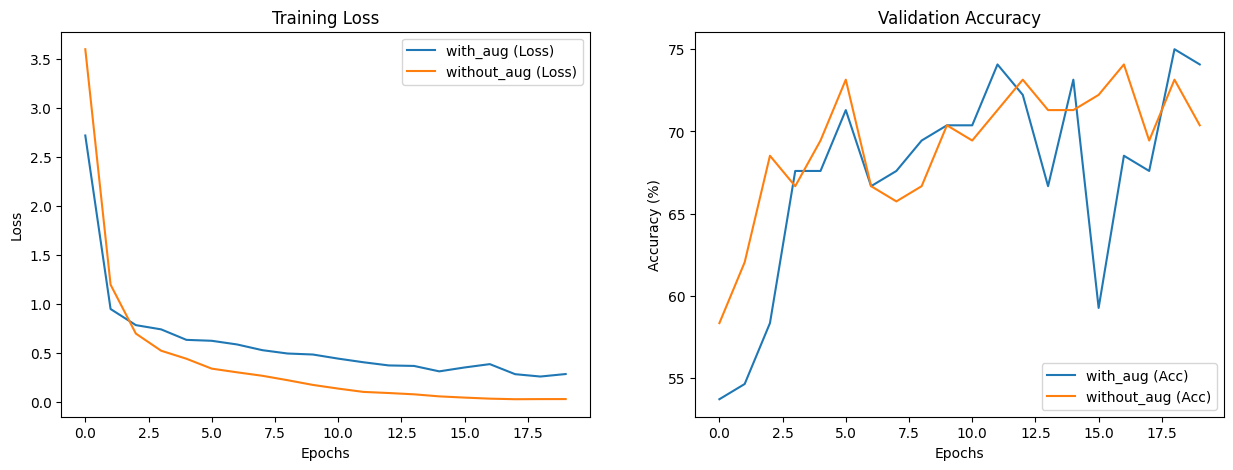

In [76]:
train_loader, val_loader = get_loaders(use_augmentation=True)
model = RegularizedShallowCNN(dropout_rate=0)
with_aug_exp = CNNExperiment(model, train_loader, val_loader)
with_aug_exp.run(epochs=20, lr=1e-3)

train_loader, val_loader = get_loaders(use_augmentation=False)
model = RegularizedShallowCNN(dropout_rate=0)
without_aug_exp = CNNExperiment(model, train_loader, val_loader)
without_aug_exp.run(epochs=20, lr=1e-3)


plot_experiment_results([with_aug_exp.history, without_aug_exp.history], ["with_aug", "without_aug"])

### Experiment 2: with vs without Dropout
* We hypothesized that Dropout would improve generalization.
* However, due to the aggressive bottleneck in our architecture (compressing 16,384 features to 128), the network lacked the redundancy required for Dropout to work.
* The experiment proved that for narrow architectures, Data Augmentation is a superior regularizer compared to Dropout.
* Therefore, as described in Experiment 2.1, we tried to change architecture to solve the "Bottleneck" by making the number of neurons in fc1 and fc2 wider (512 compared to 128) to get better accuracies.

Using cpu device
--------- start experiment with: epochs=20 | lr=0.001 | batch_size=32---------
Epoch 1/20 - Loss: 5.5988, Val Acc: 50.93%
Epoch 2/20 - Loss: 1.4835, Val Acc: 41.67%
Epoch 3/20 - Loss: 1.0981, Val Acc: 59.26%
Epoch 4/20 - Loss: 0.6941, Val Acc: 61.11%
Epoch 5/20 - Loss: 0.5941, Val Acc: 66.67%
Epoch 6/20 - Loss: 0.5377, Val Acc: 70.37%
Epoch 7/20 - Loss: 0.5171, Val Acc: 67.59%
Epoch 8/20 - Loss: 0.5395, Val Acc: 68.52%
Epoch 9/20 - Loss: 0.4756, Val Acc: 62.04%
Epoch 10/20 - Loss: 0.5215, Val Acc: 61.11%
Epoch 11/20 - Loss: 0.4869, Val Acc: 65.74%
Epoch 12/20 - Loss: 0.4087, Val Acc: 69.44%
Epoch 13/20 - Loss: 0.3634, Val Acc: 68.52%
Epoch 14/20 - Loss: 0.3988, Val Acc: 67.59%
Epoch 15/20 - Loss: 0.4344, Val Acc: 66.67%
Epoch 16/20 - Loss: 0.4625, Val Acc: 68.52%
Epoch 17/20 - Loss: 0.3276, Val Acc: 62.04%
Epoch 18/20 - Loss: 0.3193, Val Acc: 65.74%
Epoch 19/20 - Loss: 0.3112, Val Acc: 64.81%
Epoch 20/20 - Loss: 0.3912, Val Acc: 67.59%
Using cpu device
--------- start 

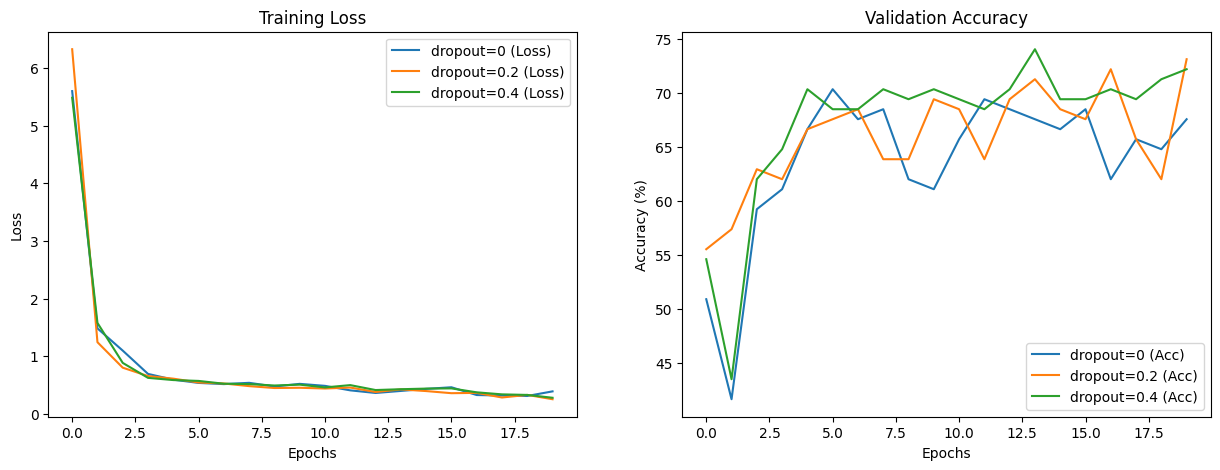

In [81]:
train_loader, val_loader = get_loaders(use_augmentation=True)
dropouts = [0, 0.2, 0.4]
experiments = {}

for dropout in dropouts:
    model = RegularizedShallowCNN(dropout_rate=dropout)
    experiment = CNNExperiment(model, train_loader, val_loader)
    experiment.run(epochs=20, lr=1e-3)
    experiments[f"dropout={dropout}"] = experiment

plot_experiment_results([e.history for e in experiments.values()], experiments.keys())

### Experiment 2.1: Wide fc layers architecture with dropout vs narrow fc layers architecture without dropout

Using cpu device
--------- start experiment with: epochs=20 | lr=0.001 | batch_size=32---------
Epoch 1/20 - Loss: 2.3989, Val Acc: 57.41%
Epoch 2/20 - Loss: 0.8908, Val Acc: 57.41%
Epoch 3/20 - Loss: 0.7081, Val Acc: 64.81%
Epoch 4/20 - Loss: 0.6453, Val Acc: 59.26%
Epoch 5/20 - Loss: 0.6948, Val Acc: 66.67%
Epoch 6/20 - Loss: 0.6229, Val Acc: 66.67%
Epoch 7/20 - Loss: 0.6763, Val Acc: 66.67%
Epoch 8/20 - Loss: 0.6554, Val Acc: 65.74%
Epoch 9/20 - Loss: 0.5965, Val Acc: 68.52%
Epoch 10/20 - Loss: 0.5842, Val Acc: 68.52%
Epoch 11/20 - Loss: 0.5543, Val Acc: 65.74%
Epoch 12/20 - Loss: 0.5238, Val Acc: 68.52%
Epoch 13/20 - Loss: 0.5273, Val Acc: 73.15%
Epoch 14/20 - Loss: 0.5506, Val Acc: 72.22%
Epoch 15/20 - Loss: 0.4968, Val Acc: 69.44%
Epoch 16/20 - Loss: 0.5181, Val Acc: 68.52%
Epoch 17/20 - Loss: 0.5017, Val Acc: 70.37%
Epoch 18/20 - Loss: 0.4684, Val Acc: 69.44%
Epoch 19/20 - Loss: 0.4892, Val Acc: 70.37%
Epoch 20/20 - Loss: 0.4266, Val Acc: 73.15%
Using cpu device
--------- start 

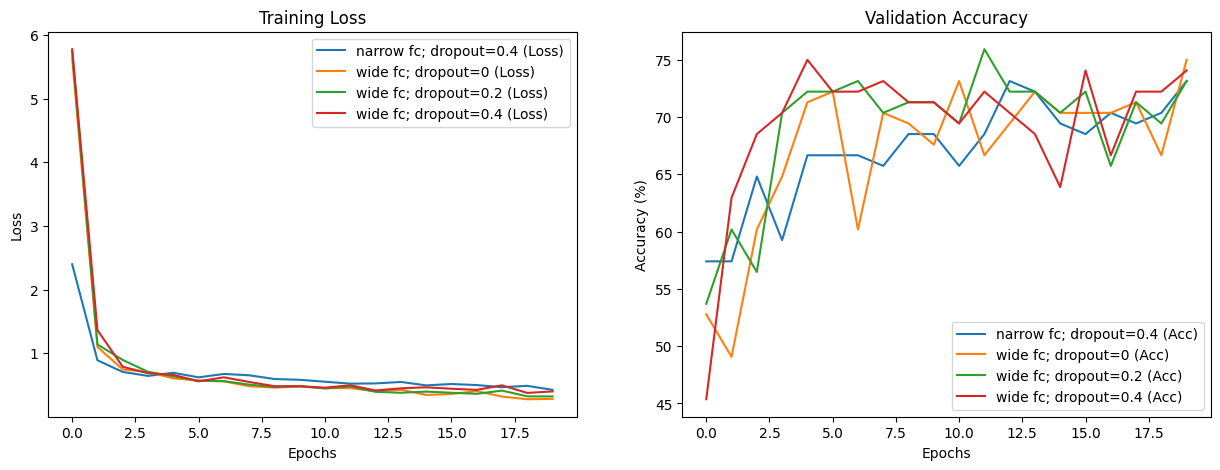

In [14]:
train_loader, val_loader = get_loaders(use_augmentation=True)
dropouts = [0, 0.2, 0.4]
experiments = {}

model = RegularizedShallowCNN(dropout_rate=0.4)
experiment = CNNExperiment(model, train_loader, val_loader)
experiment.run(epochs=20, lr=1e-3)
experiments[f"narrow fc; dropout=0.4"] = experiment.history

for dropout in dropouts:
    model = RegularizedShallowCNN(dropout_rate=dropout)
    model.fc1 = nn.Linear(64 * 16 * 16, 512)
    model.fc2 = nn.Linear(512, 3)
    experiment = CNNExperiment(model, train_loader, val_loader)
    experiment.run(epochs=20, lr=1e-3)
    experiments[f"wide fc; dropout={dropout}"] = experiment.history

plot_experiment_results(experiments.values(), experiments.keys())

### Experiment 3: with vs without weight decay
* The experiment confirmed that Weight Decay (L2 Regularization) helps improve generalization for the "Wide" architecture.
* Optimal value was: 1e-3 which achieved a peak accuracy of 75.00%.



Using cpu device
--------- start experiment with: epochs=20 | lr=0.001 | batch_size=32---------
Epoch 1/20 - Loss: 6.4132, Val Acc: 58.33%
Epoch 2/20 - Loss: 1.0957, Val Acc: 62.04%
Epoch 3/20 - Loss: 0.7991, Val Acc: 70.37%
Epoch 4/20 - Loss: 0.5590, Val Acc: 73.15%
Epoch 5/20 - Loss: 0.5260, Val Acc: 72.22%
Epoch 6/20 - Loss: 0.4008, Val Acc: 72.22%
Epoch 7/20 - Loss: 0.3572, Val Acc: 69.44%
Epoch 8/20 - Loss: 0.3743, Val Acc: 75.93%
Epoch 9/20 - Loss: 0.2442, Val Acc: 70.37%
Epoch 10/20 - Loss: 0.1954, Val Acc: 73.15%
Epoch 11/20 - Loss: 0.1748, Val Acc: 70.37%
Epoch 12/20 - Loss: 0.1432, Val Acc: 71.30%
Epoch 13/20 - Loss: 0.1285, Val Acc: 71.30%
Epoch 14/20 - Loss: 0.1093, Val Acc: 69.44%
Epoch 15/20 - Loss: 0.0974, Val Acc: 71.30%
Epoch 16/20 - Loss: 0.0926, Val Acc: 73.15%
Epoch 17/20 - Loss: 0.0779, Val Acc: 73.15%
Epoch 18/20 - Loss: 0.0609, Val Acc: 64.81%
Epoch 19/20 - Loss: 0.0409, Val Acc: 75.00%
Epoch 20/20 - Loss: 0.0552, Val Acc: 67.59%
Using cpu device
--------- start 

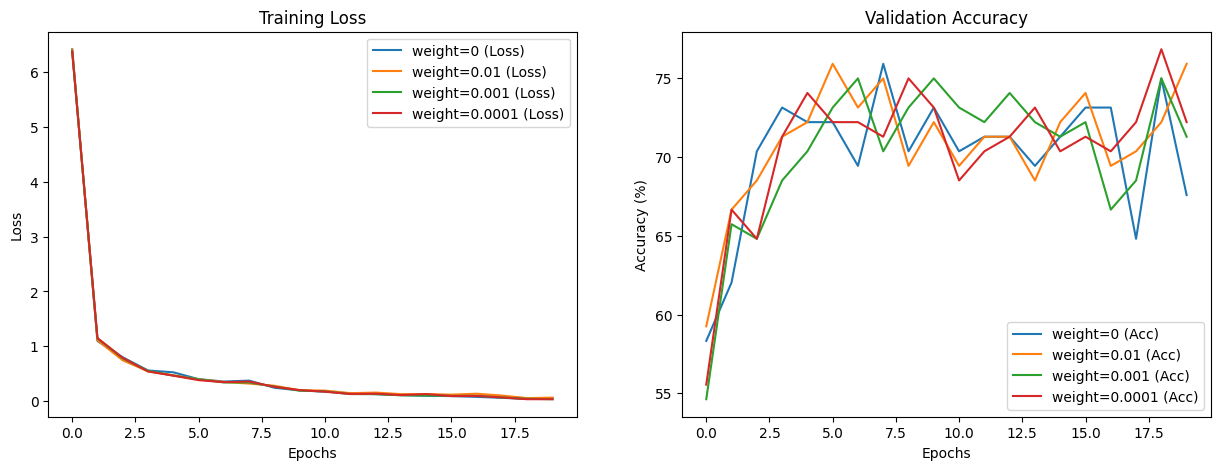

In [13]:
train_loader, val_loader = get_loaders()
experiments = {}
weight_decays = [0,1e-2, 1e-3, 1e-4]

for wd in weight_decays:
    model = RegularizedShallowCNN(dropout_rate=0.2)
    model.fc1 = nn.Linear(64 * 16 * 16, 512)
    model.fc2 = nn.Linear(512, 3)
    experiment = CNNExperiment(model, train_loader, val_loader)
    experiment.run(epochs=20, lr=1e-3, weight_decay=wd)
    experiments[f"weight={wd}"] = experiment


plot_experiment_results([e.history for e in experiments.values()], experiments.keys())

## step 3 - Conclusions
* **Batch Normalization:**  This method significantly improved generalization by preventing the model from memorizing the training data (overfitting), raising validation accuracy from 70% to 74%.
* **Data Augmentation:** We found this method as a valuable regularization method - forcing the model to learn robust features invariant to orientation rather than static pixels.
* **Dropout:** This method didn’t improve significantly the performance in our optimal "narrow" architecture because the layer was too small (128 units), meaning every neuron was critical and the network lacked the redundancy required for dropout to work. Therefore, we move with wider architecture which compresses 16384 to 512 instead of 16384 to 128 and use dropout of 0.2
* **Weight Decay:** L2 regularization proved beneficial for the wider architecture; specifically, a decay of 1e-4 founded as the optimal balance between bias and variance, matching the peak accuracy of 76.85%.



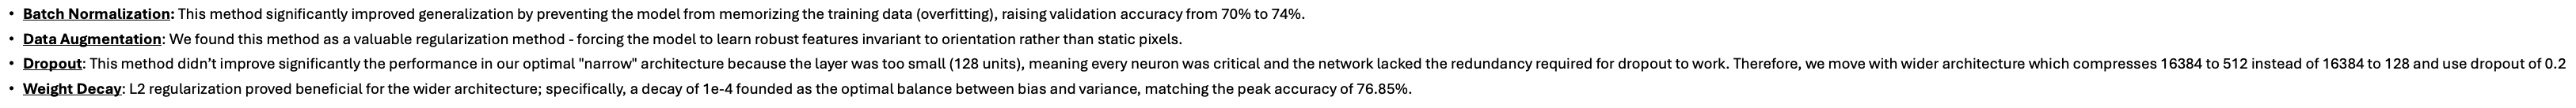
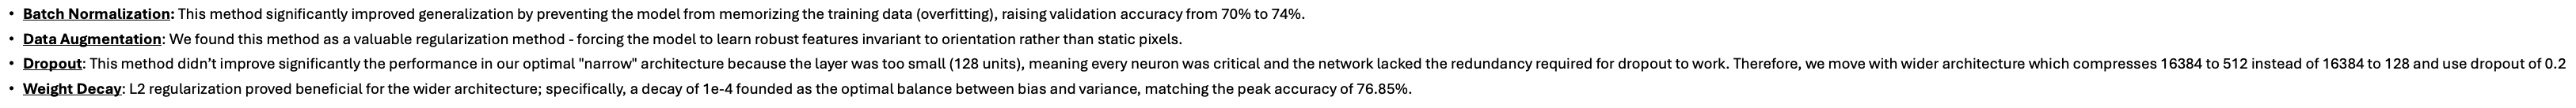
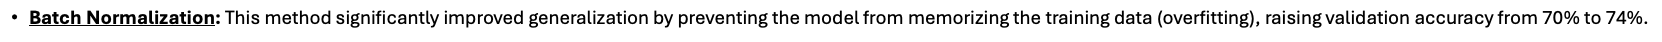
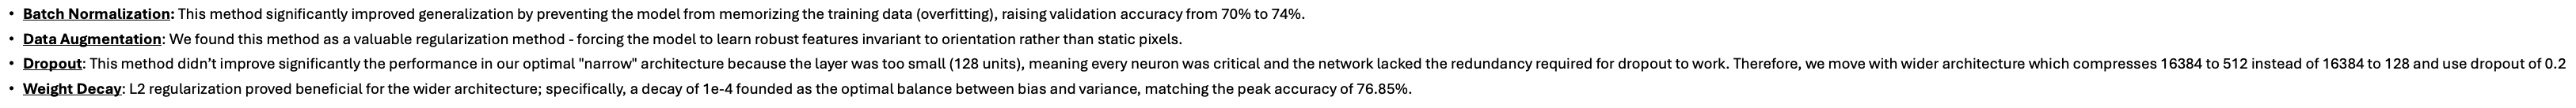

## Final Network Classification Analysis

Using cpu device
--------- start experiment with: epochs=19 | lr=0.001 | batch_size=32---------
Epoch 1/19 - Loss: 6.3722, Val Acc: 55.56%
Epoch 2/19 - Loss: 1.1493, Val Acc: 66.67%
Epoch 3/19 - Loss: 0.7891, Val Acc: 64.81%
Epoch 4/19 - Loss: 0.5406, Val Acc: 71.30%
Epoch 5/19 - Loss: 0.4656, Val Acc: 74.07%
Epoch 6/19 - Loss: 0.3826, Val Acc: 72.22%
Epoch 7/19 - Loss: 0.3464, Val Acc: 72.22%
Epoch 8/19 - Loss: 0.3578, Val Acc: 71.30%
Epoch 9/19 - Loss: 0.2606, Val Acc: 75.00%
Epoch 10/19 - Loss: 0.2020, Val Acc: 73.15%
Epoch 11/19 - Loss: 0.1722, Val Acc: 68.52%
Epoch 12/19 - Loss: 0.1311, Val Acc: 70.37%
Epoch 13/19 - Loss: 0.1359, Val Acc: 71.30%
Epoch 14/19 - Loss: 0.1112, Val Acc: 73.15%
Epoch 15/19 - Loss: 0.1293, Val Acc: 70.37%
Epoch 16/19 - Loss: 0.0925, Val Acc: 71.30%
Epoch 17/19 - Loss: 0.0952, Val Acc: 70.37%
Epoch 18/19 - Loss: 0.0676, Val Acc: 72.22%
Epoch 19/19 - Loss: 0.0353, Val Acc: 76.85%


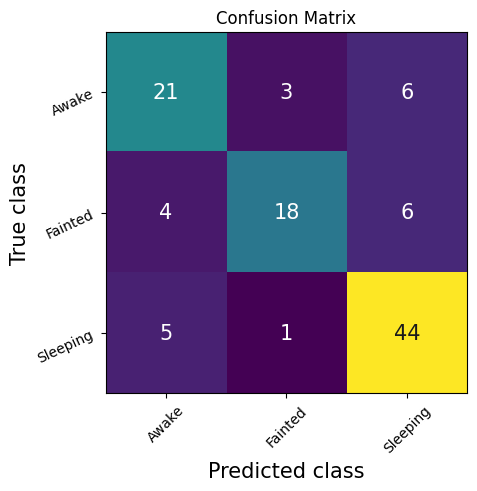

In [16]:
train_loader, val_loader = get_loaders()
model = RegularizedShallowCNN(dropout_rate=0.2)
model.fc1 = nn.Linear(64 * 16 * 16, 512)
model.fc2 = nn.Linear(512, 3)
experiment = CNNExperiment(model, train_loader, val_loader)
experiment.run(epochs=19, lr=1e-3, weight_decay=1e-4)
plot_confusion_matrix(model, val_loader, experiment.device)

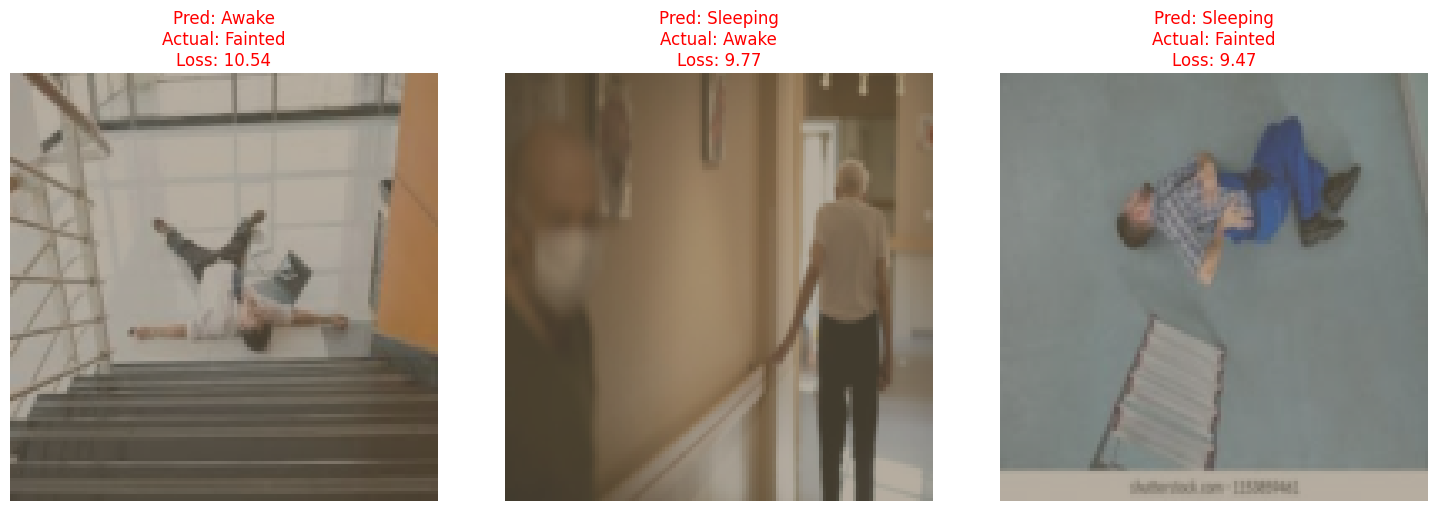

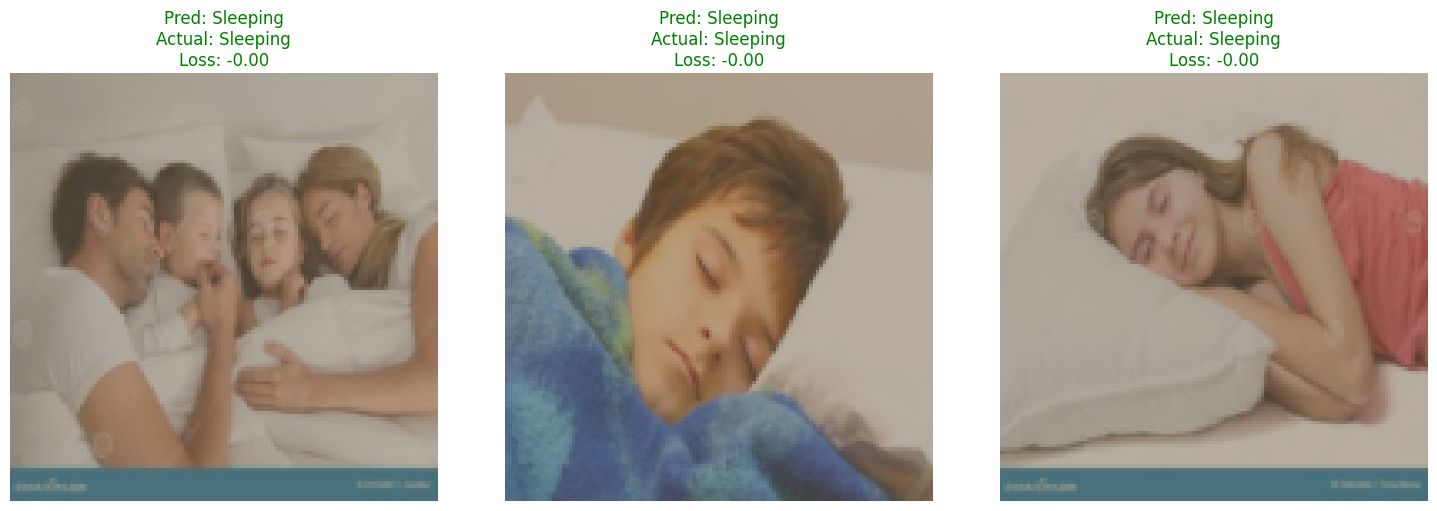

In [17]:
top_losses, best_preds = get_top_bottom_losses(model, val_loader, experiment.device, n=3)
plot_top_losses(top_losses)
plot_top_losses(best_preds)

# Part 2 - Transfer learning

In [143]:
class CNN2_CIFAR(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.0):
        torch.manual_seed(42)
        super(CNN2_CIFAR, self).__init__()

        # Input: (3, 32, 32) -> Conv -> (16, 32, 32) -> Pool -> (16, 16, 16)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Input: (16, 16, 16) -> Conv -> (32, 16, 16) -> Pool -> (32, 8, 8)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # Input: (32, 8, 8) -> Conv -> (64, 8, 8) -> Pool -> (64, 4, 4)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## Load Data

In [142]:
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

transform = transforms.Compose([
    # transforms.Resize((128, 128)), # Upscale to match your architecture
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Standard normalization
])


trainset = datasets.CIFAR10(root='./CIFAR-10', train=True,
                                        download=True, transform=transform)
# CIFAR is large (50k images), so we can use a larger batch size (e.g., 64 or 128)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testset = datasets.CIFAR10(root='./CIFAR-10', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')



## Experiment 1: LR

Using cpu device
--------- start experiment with: epochs=10 | lr=0.01 | batch_size=128---------
Epoch 1/10 - Loss: 1.6584, Val Acc: 53.36%
Epoch 2/10 - Loss: 1.1516, Val Acc: 62.90%
Epoch 3/10 - Loss: 0.9629, Val Acc: 65.32%
Epoch 4/10 - Loss: 0.8637, Val Acc: 64.76%
Epoch 5/10 - Loss: 0.7930, Val Acc: 68.26%
Epoch 6/10 - Loss: 0.7451, Val Acc: 69.26%
Epoch 7/10 - Loss: 0.7044, Val Acc: 70.28%
Epoch 8/10 - Loss: 0.6633, Val Acc: 71.01%
Epoch 9/10 - Loss: 0.6348, Val Acc: 70.81%
Epoch 10/10 - Loss: 0.6102, Val Acc: 71.39%
Using cpu device
--------- start experiment with: epochs=10 | lr=0.001 | batch_size=128---------
Epoch 1/10 - Loss: 1.2616, Val Acc: 61.89%
Epoch 2/10 - Loss: 0.9153, Val Acc: 67.83%
Epoch 3/10 - Loss: 0.7917, Val Acc: 69.22%
Epoch 4/10 - Loss: 0.7142, Val Acc: 69.83%
Epoch 5/10 - Loss: 0.6508, Val Acc: 72.17%
Epoch 6/10 - Loss: 0.6024, Val Acc: 73.81%
Epoch 7/10 - Loss: 0.5542, Val Acc: 72.33%
Epoch 8/10 - Loss: 0.5157, Val Acc: 74.10%
Epoch 9/10 - Loss: 0.4813, Val A

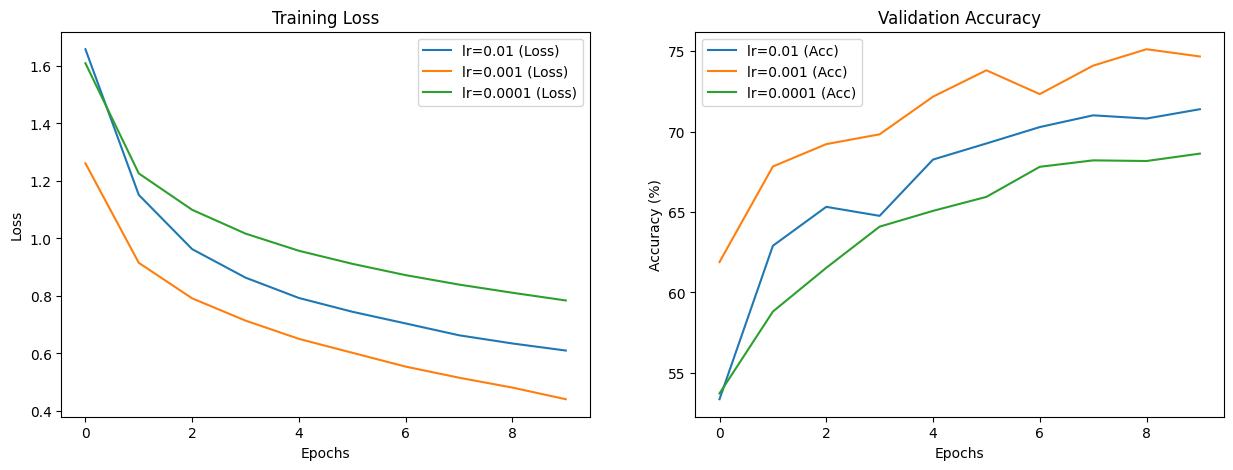

In [104]:
lrs = [1e-2, 1e-3, 1e-4]
experiments = {}
for lr in lrs:
    model = CNN2_CIFAR(num_classes=10)
    experiment = CNNExperiment(model, trainloader, testloader)
    experiment.run(epochs=10, lr=lr)
    experiments[f"lr={lr}"] = experiment.history

plot_experiment_results(experiments.values(), experiments.keys())

### Run final configuration and save weights

In [52]:
model = CNN2_CIFAR(num_classes=10)
experiment = CNNExperiment(model, trainloader, testloader)
experiment.run(epochs=15, lr=1e-3, save_model=True)


Using cpu device
--------- start experiment with: epochs=15 | lr=0.001 | batch_size=128---------
New record! Model saved with accuracy: 63.5%
Epoch 1/15 - Loss: 1.2716, Val Acc: 63.50%
New record! Model saved with accuracy: 67.6%
Epoch 2/15 - Loss: 0.9255, Val Acc: 67.60%
New record! Model saved with accuracy: 68.94%
Epoch 3/15 - Loss: 0.8008, Val Acc: 68.94%
New record! Model saved with accuracy: 71.71%
Epoch 4/15 - Loss: 0.7252, Val Acc: 71.71%
New record! Model saved with accuracy: 72.49%
Epoch 5/15 - Loss: 0.6577, Val Acc: 72.49%
Epoch 6/15 - Loss: 0.6052, Val Acc: 70.98%
New record! Model saved with accuracy: 73.05%
Epoch 7/15 - Loss: 0.5574, Val Acc: 73.05%
New record! Model saved with accuracy: 75.24%
Epoch 8/15 - Loss: 0.5141, Val Acc: 75.24%
Epoch 9/15 - Loss: 0.4715, Val Acc: 74.85%
Epoch 10/15 - Loss: 0.4326, Val Acc: 74.84%
Epoch 11/15 - Loss: 0.4055, Val Acc: 74.79%
New record! Model saved with accuracy: 75.4%
Epoch 12/15 - Loss: 0.3725, Val Acc: 75.40%
Epoch 13/15 - Loss:

### Modify the fc head back to match our dataset resize:

In [140]:
def get_transfer_model(path_to_cifar_weights, num_classes=3, dropout_rate=0.0):
    # Initialize the Model exactly as it was for CIFAR (32x32 version)
    model = CNN2_CIFAR(num_classes=10, dropout_rate=dropout_rate)

    # Load the Learned Weights
    print(f"Loading weights from {path_to_cifar_weights}...")
    state_dict = torch.load(path_to_cifar_weights, map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)
    print("Weights loaded successfully!")

    # Freeze the Convolutional Layers to keep the weights we had after pre-train
    for param in model.parameters():
        param.requires_grad = False

    print("Modifying Fully Connected layers for 128x128 input...")
    model.fc1 = nn.Linear(64 * 16 * 16, 128)
    model.fc2 = nn.Linear(128, num_classes)

    return model



## Fine-Tuning on our dataset

### Experiment 1: Learning rate fine tuning
* After review several learning rates, we decided to move forward with lr=1e-3

Loading weights from ./models/best_cifar10_model.pth...
Weights loaded successfully!
Modifying Fully Connected layers for 128x128 input...
Using cpu device
--------- start experiment with: epochs=20 | lr=0.01 | batch_size=32---------
Epoch 1/20 - Loss: 30.1134, Val Acc: 36.11%
Epoch 2/20 - Loss: 1.7643, Val Acc: 44.44%
Epoch 3/20 - Loss: 0.9676, Val Acc: 49.07%
Epoch 4/20 - Loss: 0.8500, Val Acc: 64.81%
Epoch 5/20 - Loss: 0.7986, Val Acc: 66.67%
Epoch 6/20 - Loss: 0.7345, Val Acc: 68.52%
Epoch 7/20 - Loss: 0.7407, Val Acc: 69.44%
Epoch 8/20 - Loss: 0.6831, Val Acc: 68.52%
Epoch 9/20 - Loss: 0.6408, Val Acc: 68.52%
Epoch 10/20 - Loss: 0.6728, Val Acc: 67.59%
Epoch 11/20 - Loss: 0.6072, Val Acc: 72.22%
Epoch 12/20 - Loss: 0.5571, Val Acc: 70.37%
Epoch 13/20 - Loss: 0.5546, Val Acc: 68.52%
Epoch 14/20 - Loss: 0.5929, Val Acc: 66.67%
Epoch 15/20 - Loss: 0.5498, Val Acc: 70.37%
Epoch 16/20 - Loss: 0.5310, Val Acc: 71.30%
Epoch 17/20 - Loss: 0.5057, Val Acc: 71.30%
Epoch 18/20 - Loss: 0.4762

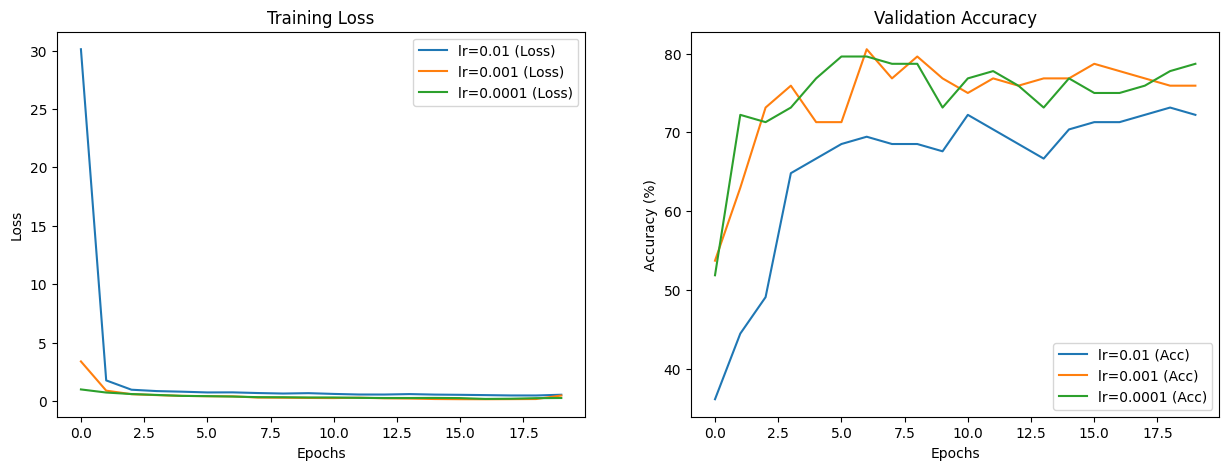

In [98]:
cifar_weights_path = './models/best_cifar10_model.pth'
train_loader, val_loader = get_loaders(use_augmentation=True)
lrs = [1e-2, 1e-3, 1e-4]
experiments = {}

for lr in lrs:
    transfer_model = get_transfer_model(cifar_weights_path, num_classes=3)
    exp = CNNExperiment(transfer_model, train_loader, val_loader)
    exp.run(epochs=20, lr=lr)
    experiments[f"lr={lr}"] = exp.history

plot_experiment_results(experiments.values(),experiments.keys())

### Experiment 2: batch size fine tuning
* The experiment identified Batch Size 32 as the optimal setting for fine-tuning the pre-trained network.

Loading weights from ./models/best_cifar10_model.pth...
Weights loaded successfully!
Modifying Fully Connected layers for 128x128 input...
Using cpu device
--------- start experiment with: epochs=20 | lr=0.001 | batch_size=16---------
Epoch 1/20 - Loss: 2.3917, Val Acc: 50.93%
Epoch 2/20 - Loss: 0.7829, Val Acc: 69.44%
Epoch 3/20 - Loss: 0.5697, Val Acc: 72.22%
Epoch 4/20 - Loss: 0.5350, Val Acc: 67.59%
Epoch 5/20 - Loss: 0.4991, Val Acc: 75.93%
Epoch 6/20 - Loss: 0.3699, Val Acc: 76.85%
Epoch 7/20 - Loss: 0.4108, Val Acc: 75.93%
Epoch 8/20 - Loss: 0.2623, Val Acc: 74.07%
Epoch 9/20 - Loss: 0.2773, Val Acc: 77.78%
Epoch 10/20 - Loss: 0.2517, Val Acc: 78.70%
Epoch 11/20 - Loss: 0.2466, Val Acc: 78.70%
Epoch 12/20 - Loss: 0.2294, Val Acc: 75.93%
Epoch 13/20 - Loss: 0.1787, Val Acc: 76.85%
Epoch 14/20 - Loss: 0.1659, Val Acc: 75.93%
Epoch 15/20 - Loss: 0.1375, Val Acc: 78.70%
Epoch 16/20 - Loss: 0.2099, Val Acc: 77.78%
Epoch 17/20 - Loss: 0.1113, Val Acc: 78.70%
Epoch 18/20 - Loss: 0.1449

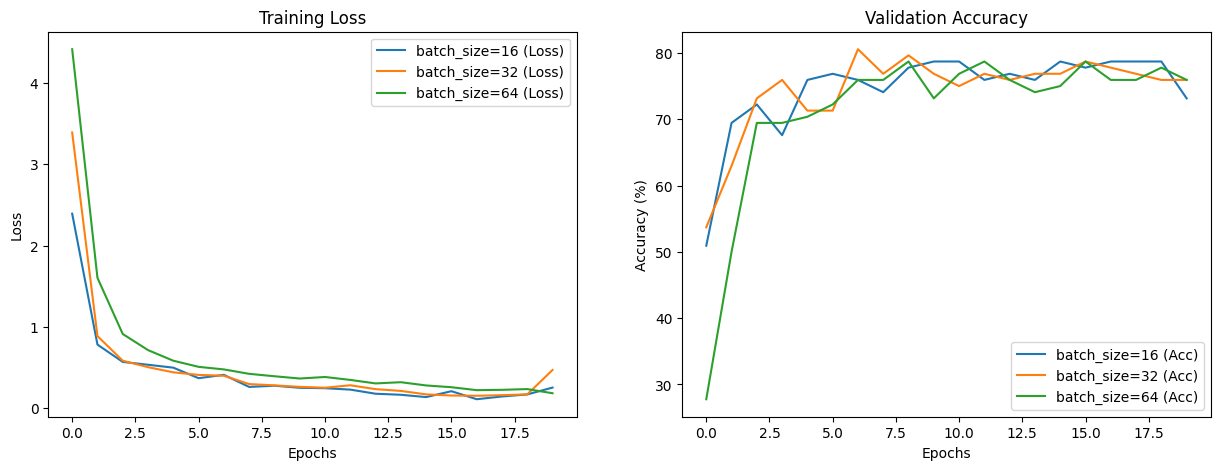

In [99]:
cifar_weights_path = './models/best_cifar10_model.pth'

batch_sizes = [16, 32, 64]
experiments = {}

for size in batch_sizes:
    train_loader, val_loader = get_loaders(batch_size=size, use_augmentation=True)
    transfer_model = get_transfer_model(cifar_weights_path, num_classes=3)
    exp = CNNExperiment(transfer_model, train_loader, val_loader)
    exp.run(epochs=20, lr=1e-3)
    experiments[f"batch_size={size}"] = exp.history

plot_experiment_results(experiments.values(),experiments.keys())

### Experiment 3: wight decay fine tuning

Loading weights from ./models/best_cifar10_model.pth...
Weights loaded successfully!
Modifying Fully Connected layers for 128x128 input...
Using cpu device
--------- start experiment with: epochs=20 | lr=0.001 | batch_size=32---------
Epoch 1/20 - Loss: 3.3898, Val Acc: 53.70%
Epoch 2/20 - Loss: 0.8873, Val Acc: 62.96%
Epoch 3/20 - Loss: 0.5845, Val Acc: 73.15%
Epoch 4/20 - Loss: 0.5054, Val Acc: 75.93%
Epoch 5/20 - Loss: 0.4418, Val Acc: 71.30%
Epoch 6/20 - Loss: 0.4102, Val Acc: 71.30%
Epoch 7/20 - Loss: 0.3998, Val Acc: 80.56%
Epoch 8/20 - Loss: 0.2975, Val Acc: 76.85%
Epoch 9/20 - Loss: 0.2815, Val Acc: 79.63%
Epoch 10/20 - Loss: 0.2631, Val Acc: 76.85%
Epoch 11/20 - Loss: 0.2524, Val Acc: 75.00%
Epoch 12/20 - Loss: 0.2827, Val Acc: 76.85%
Epoch 13/20 - Loss: 0.2352, Val Acc: 75.93%
Epoch 14/20 - Loss: 0.2134, Val Acc: 76.85%
Epoch 15/20 - Loss: 0.1706, Val Acc: 76.85%
Epoch 16/20 - Loss: 0.1568, Val Acc: 78.70%
Epoch 17/20 - Loss: 0.1538, Val Acc: 77.78%
Epoch 18/20 - Loss: 0.1613

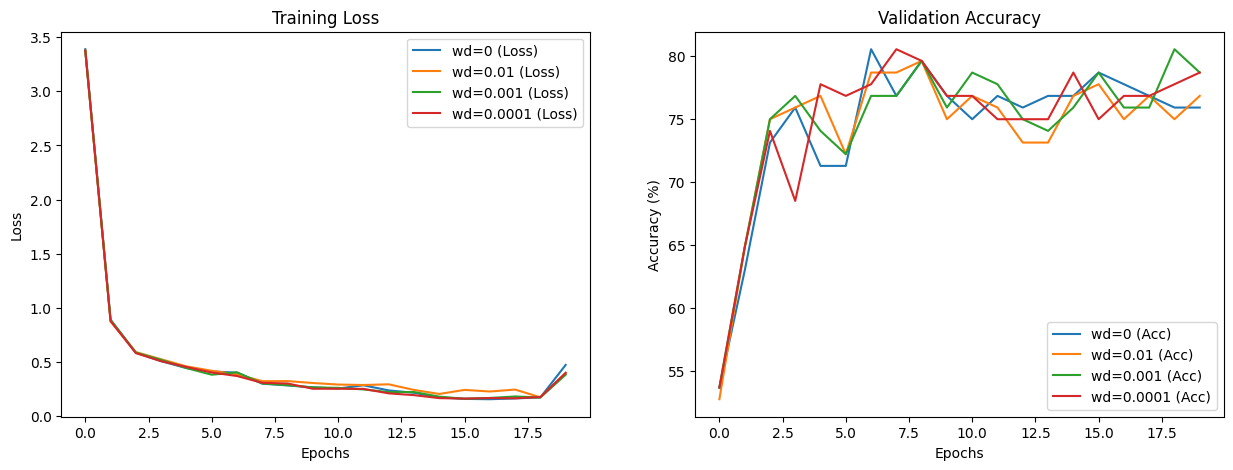

In [100]:
cifar_weights_path = './models/best_cifar10_model.pth'
train_loader, val_loader = get_loaders(batch_size=32, use_augmentation=True)

weight_decays = [0, 1e-2, 1e-3, 1e-4]
experiments = {}

for wd in weight_decays:
    transfer_model = get_transfer_model(cifar_weights_path, num_classes=3)
    exp = CNNExperiment(transfer_model, train_loader, val_loader)
    exp.run(epochs=20, lr=1e-3, weight_decay=wd)
    experiments[f"wd={wd}"] = exp.history

plot_experiment_results(experiments.values(),experiments.keys())

### Experiment 4: dropout fine tuning
* The experiment demonstrates that dropout p=0.4 was the most effective regularization strategy for the fine-tuned network.
* While the baseline model achieved low training loss (0.11), it plateaued at 80.56% accuracy.
* Increasing the dropout rate to 0.4 kept the training loss higher (preventing memorization) but allowed the model to reach a superior validation accuracy of 81.48%.
* This suggests that for this specific transfer learning task, a stronger regularization penalty was necessary to maximize generalization.

Loading weights from ./models/best_cifar10_model.pth...
Weights loaded successfully!
Modifying Fully Connected layers for 128x128 input...
Using cpu device
--------- start experiment with: epochs=20 | lr=0.001 | batch_size=32---------
Epoch 1/20 - Loss: 3.3898, Val Acc: 53.70%
Epoch 2/20 - Loss: 0.8873, Val Acc: 62.96%
Epoch 3/20 - Loss: 0.5845, Val Acc: 73.15%
Epoch 4/20 - Loss: 0.5054, Val Acc: 75.93%
Epoch 5/20 - Loss: 0.4418, Val Acc: 71.30%
Epoch 6/20 - Loss: 0.4102, Val Acc: 71.30%
Epoch 7/20 - Loss: 0.3998, Val Acc: 80.56%
Epoch 8/20 - Loss: 0.2975, Val Acc: 76.85%
Epoch 9/20 - Loss: 0.2815, Val Acc: 79.63%
Epoch 10/20 - Loss: 0.2631, Val Acc: 76.85%
Epoch 11/20 - Loss: 0.2524, Val Acc: 75.00%
Epoch 12/20 - Loss: 0.2827, Val Acc: 76.85%
Epoch 13/20 - Loss: 0.2352, Val Acc: 75.93%
Epoch 14/20 - Loss: 0.2134, Val Acc: 76.85%
Epoch 15/20 - Loss: 0.1706, Val Acc: 76.85%
Epoch 16/20 - Loss: 0.1568, Val Acc: 78.70%
Epoch 17/20 - Loss: 0.1538, Val Acc: 77.78%
Epoch 18/20 - Loss: 0.1613

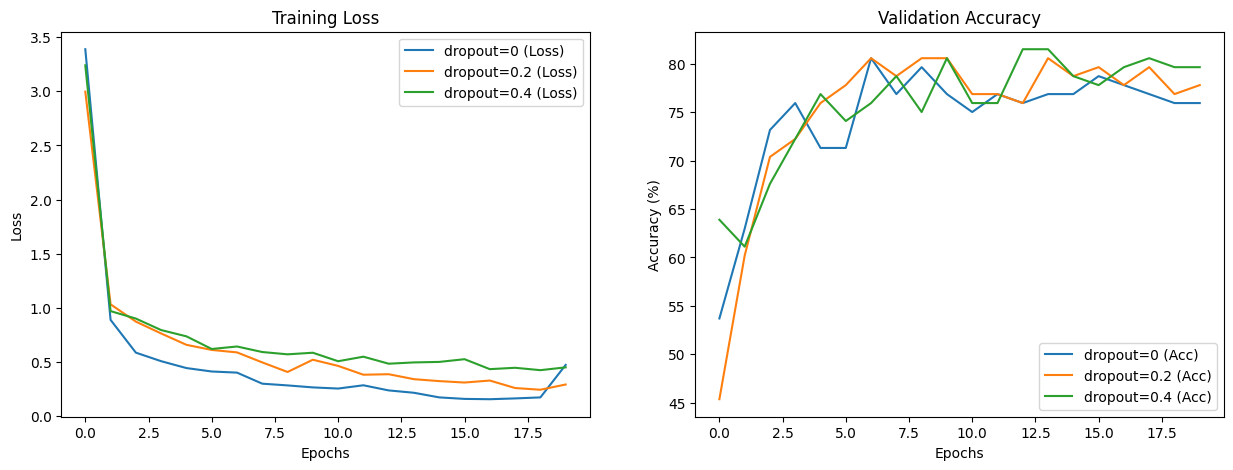

In [103]:
cifar_weights_path = './models/best_cifar10_model.pth'
train_loader, val_loader = get_loaders(batch_size=32, use_augmentation=True)

dropouts = [0, 0.2, 0.4]
experiments = {}

for dropout in dropouts:
    transfer_model = get_transfer_model(cifar_weights_path, num_classes=3, dropout_rate=dropout)
    exp = CNNExperiment(transfer_model, train_loader, val_loader)
    exp.run(epochs=20, lr=1e-3)
    experiments[f"dropout={dropout}"] = exp.history

plot_experiment_results(experiments.values(),experiments.keys())

### Final network classification analysis

Loading weights from ./models/best_cifar10_model.pth...
Weights loaded successfully!
Modifying Fully Connected layers for 128x128 input...
Using cpu device
--------- start experiment with: epochs=20 | lr=0.001 | batch_size=32---------
Epoch 1/20 - Loss: 3.2407, Val Acc: 63.89%
Epoch 2/20 - Loss: 0.9684, Val Acc: 61.11%
Epoch 3/20 - Loss: 0.8994, Val Acc: 67.59%
Epoch 4/20 - Loss: 0.7932, Val Acc: 72.22%
Epoch 5/20 - Loss: 0.7352, Val Acc: 76.85%
Epoch 6/20 - Loss: 0.6183, Val Acc: 74.07%
Epoch 7/20 - Loss: 0.6413, Val Acc: 75.93%
Epoch 8/20 - Loss: 0.5902, Val Acc: 78.70%
Epoch 9/20 - Loss: 0.5689, Val Acc: 75.00%
Epoch 10/20 - Loss: 0.5836, Val Acc: 80.56%
Epoch 11/20 - Loss: 0.5052, Val Acc: 75.93%
Epoch 12/20 - Loss: 0.5470, Val Acc: 75.93%
Epoch 13/20 - Loss: 0.4821, Val Acc: 81.48%
Epoch 14/20 - Loss: 0.4941, Val Acc: 81.48%
Epoch 15/20 - Loss: 0.4987, Val Acc: 78.70%
Epoch 16/20 - Loss: 0.5239, Val Acc: 77.78%
Epoch 17/20 - Loss: 0.4319, Val Acc: 79.63%
Epoch 18/20 - Loss: 0.4445

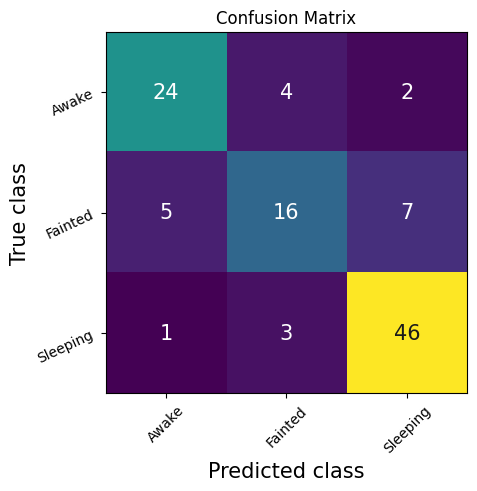

In [151]:
cifar_weights_path = './models/best_cifar10_model.pth'
train_loader, val_loader = get_loaders(batch_size=32, use_augmentation=True)
transfer_model = get_transfer_model(cifar_weights_path, num_classes=3, dropout_rate=0.4)
exp = CNNExperiment(transfer_model, train_loader, val_loader)
exp.run(epochs=20, lr=1e-3)

plot_confusion_matrix(transfer_model, val_loader, exp.device)

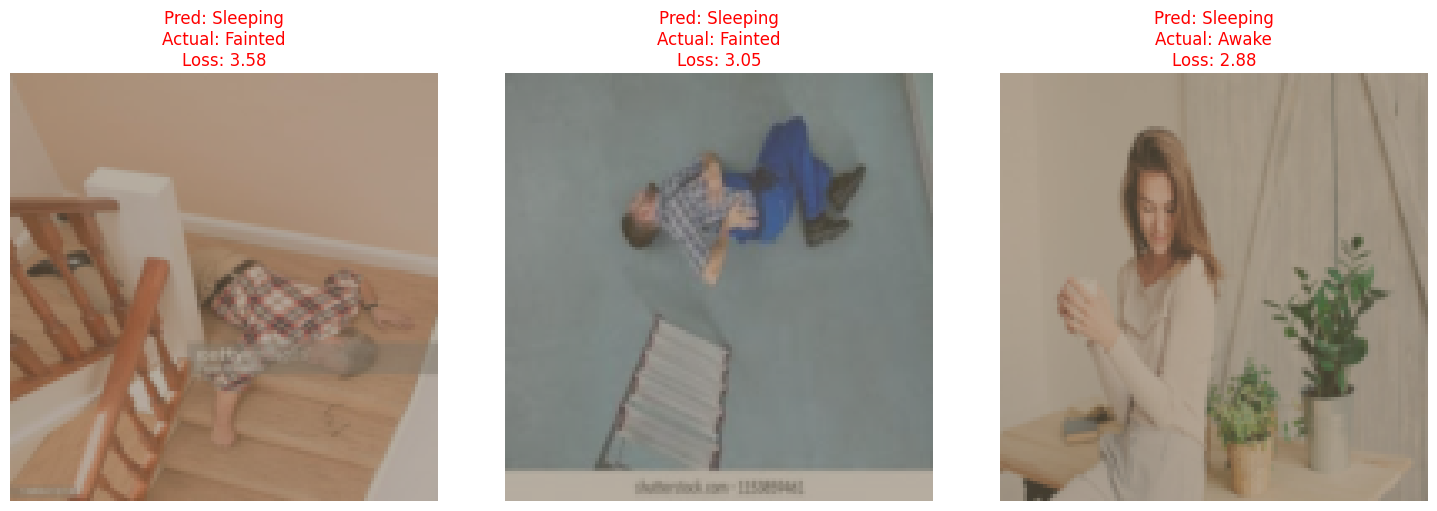

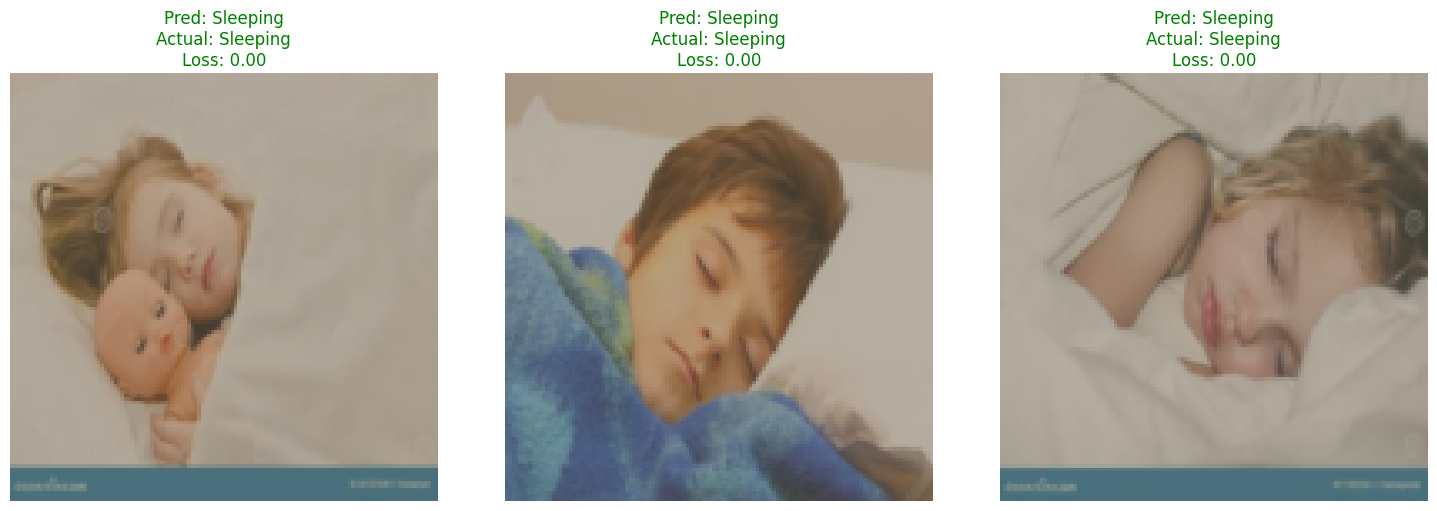

In [152]:
top_losses, best_preds = get_top_bottom_losses(transfer_model, val_loader, exp.device, n=3)
plot_top_losses(top_losses)
plot_top_losses(best_preds)

## Part 2: Conclusion
In this part, we employed a Transfer Learning strategy to overcome the limitations of a small dataset.

**Methodology**: We first pre-trained a Convolutional Neural Network (CNN2_CIFAR) on the larger CIFAR-10 dataset to learn general visual features (edges, shapes, textures). We then transferred these weights to our specific task, modifying only the fully connected layers to match our input size (128x128) and class count.

**Optimization**: Through experimentation, we identified that a Batch Size of 32 provided the best balance for convergence, and a high Dropout rate of 0.4 was necessary to regularize the dense features, achieving a peak validation accuracy of 81.48%.

key differences:
*    Best Accuracy: 81.48% (Part 1: 75%)
*   Speed of convergence: faster than Part 1

While our Weight Decay experiment suggested that the model didn't need magnitude constraints (keeping weights small), the Dropout experiment revealed that the model was suffering from feature co-adaptation.

The shift from 32x32 to 128x128 images created a massive 16,384-dimensional input vector for fc1 layer.

**Why Weight Decay failed**: Weight decay applies a global penalty to weight sizes. Since we only had a few layers to train, we needed those weights to adapt freely and strongly to the new dataset. Penalizing them hindered the learning more than it helped.

**Why Dropout succeeded**: With 16,384 incoming features, the model was prone to memorizing specific 'noisy' patterns in the feature maps. Dropout forces the network to ignore random parts of that massive input during training, ensuring it learns robust, distributed features rather than relying on specific, brittle connections.

Transfer Learning proved vastly superior to training from scratch.

By leveraging the feature maps learned from CIFAR-10, the model in Part 2 started with a "semantic understanding" of images.

This allowed it to reach a significantly higher accuracy (+6.5% improvement) and generalize better than the Part 1 model, which was limited by the small size of our specific dataset.
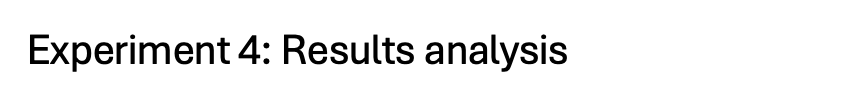
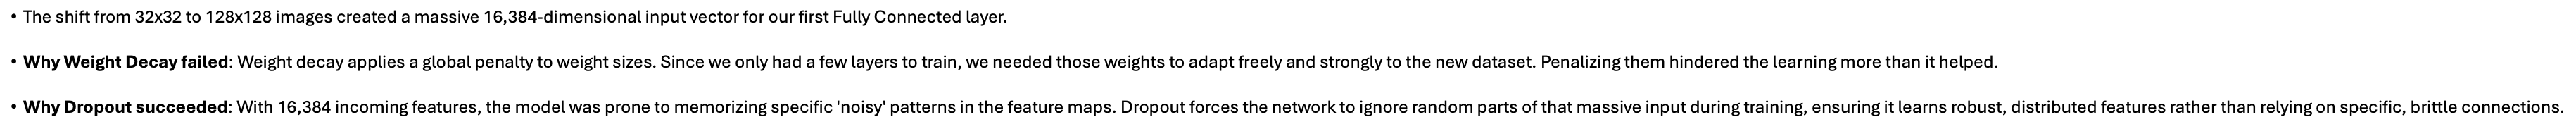

# Part 3 - Transfer learning with a Pretrained Network (ResNet50)

## Load data

In [131]:
# Define transforms
base_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

aug_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize slightly larger first
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


def get_loaders(data_root='./data', batch_size=32, train_split=0.8,
                use_augmentation=False, num_workers=4):
    np.random.seed(42)

    # Verify data directory exists
    if not os.path.exists(data_root):
        raise FileNotFoundError(f"Data directory '{data_root}' not found!")

    # Create two separate dataset instances with different transforms
    train_dataset = datasets.ImageFolder(
        root=data_root,
        transform=aug_transforms if use_augmentation else base_transforms
    )

    val_dataset = datasets.ImageFolder(
        root=data_root,
        transform=base_transforms
    )

    # Get total size and calculate split
    total_size = len(train_dataset)
    train_size = int(train_split * total_size)

    # Create indices for splitting
    indices = np.random.permutation(total_size)
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    # Create subsets using the same indices for both datasets
    train_data = Subset(train_dataset, train_indices)
    val_data = Subset(val_dataset, val_indices)

    # Create DataLoaders
    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True
    )

    val_loader = DataLoader(
        val_data,
        batch_size=batch_size,
        shuffle=False
    )

    return train_loader, val_loader

## Training setup:

In [132]:
def get_fresh_resnet():
    torch.manual_seed(42)

    # Load clean weights from ImageNet
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

    # Freeze all layers (Standard for Experiments 1 & 2)
    for param in model.parameters():
        param.requires_grad = False

    # Add your specific 3-class head
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, 3)
    )
    return model

In [136]:
class ResNetExperiment:
    def __init__(self, model, train_loader, val_loader):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = nn.CrossEntropyLoss()
        self.history = {'train_loss': [], 'val_acc': []}

    def train_epoch(self, optimizer):
        self.model.train()
        running_loss = 0.0
        for inputs, labels in self.train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)

            optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        return running_loss / len(self.train_loader)

    def evaluate(self):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return 100 * correct / total

    def run(self, epochs, lr=1e-4, unfreeze_layer4=False):
        # Configure Optimizer based on unfreezing strategy
        if not unfreeze_layer4:
            print(f"--- Running Experiment: Frozen Backbone | lr={lr} | batch_size={self.train_loader.batch_size} ---")
            optimizer = optim.Adam(self.model.fc.parameters(), lr=lr)
        else:
            print(f"--- Running Experiment: Unfrozen Layer 4 (Fine-tuning)  | lr={lr} | batch_size={self.train_loader.batch_size} ---")
            # Differential learning rates as discussed
            optimizer = optim.Adam([
                {'params': self.model.layer4.parameters(), 'lr': lr / 100},
                {'params': self.model.fc.parameters(), 'lr': lr}
            ])

        for epoch in range(epochs):
            loss = self.train_epoch(optimizer)
            acc = self.evaluate()
            self.history['train_loss'].append(loss)
            self.history['val_acc'].append(acc)
            print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f}, Val Acc: {acc:.2f}%")


In [6]:
def plot_experiment_results(histories, titles):
    """
    histories: list of history dictionaries from ResNetExperiment
    titles: list of strings describing each experiment
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    for history, title in zip(histories, titles):
        ax1.plot(history['train_loss'], label=f'{title} (Loss)')
        ax2.plot(history['val_acc'], label=f'{title} (Acc)')

    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    plt.show()

# Training & Find tuning

## Experiment 1: Learning rate fine tuning

--- Running Experiment: Frozen Backbone | lr=0.001 | batch_size=32 ---
Epoch 1/10 - Loss: 0.5894, Val Acc: 86.11%
Epoch 2/10 - Loss: 0.1629, Val Acc: 93.52%
Epoch 3/10 - Loss: 0.0961, Val Acc: 94.44%
Epoch 4/10 - Loss: 0.0573, Val Acc: 92.59%
Epoch 5/10 - Loss: 0.0607, Val Acc: 95.37%
Epoch 6/10 - Loss: 0.0318, Val Acc: 95.37%
Epoch 7/10 - Loss: 0.0670, Val Acc: 87.96%
Epoch 8/10 - Loss: 0.0307, Val Acc: 94.44%
Epoch 9/10 - Loss: 0.0127, Val Acc: 95.37%
Epoch 10/10 - Loss: 0.0265, Val Acc: 94.44%
--- Running Experiment: Frozen Backbone | lr=0.0001 | batch_size=32 ---
Epoch 1/10 - Loss: 0.9867, Val Acc: 77.78%
Epoch 2/10 - Loss: 0.7521, Val Acc: 76.85%
Epoch 3/10 - Loss: 0.5675, Val Acc: 84.26%
Epoch 4/10 - Loss: 0.4376, Val Acc: 91.67%
Epoch 5/10 - Loss: 0.3502, Val Acc: 91.67%
Epoch 6/10 - Loss: 0.2825, Val Acc: 93.52%
Epoch 7/10 - Loss: 0.2479, Val Acc: 93.52%
Epoch 8/10 - Loss: 0.2033, Val Acc: 92.59%
Epoch 9/10 - Loss: 0.1767, Val Acc: 93.52%
Epoch 10/10 - Loss: 0.1781, Val Acc: 92

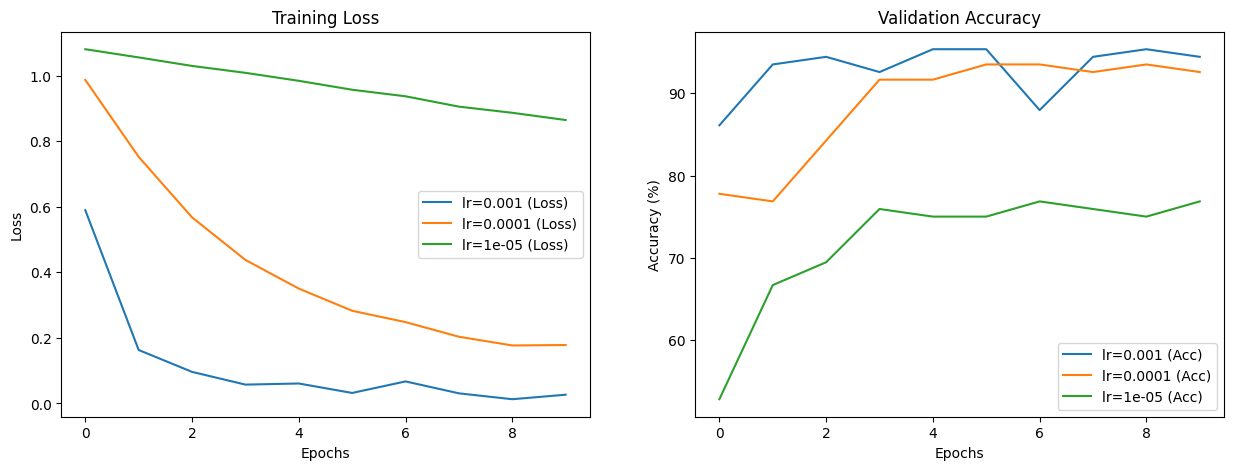

In [137]:
train_loader, val_loader = get_loaders()
lrs = [1e-3, 1e-4, 1e-5]
experiments = {}

for lr in lrs:
    model = get_fresh_resnet()
    exp = ResNetExperiment(model, train_loader, val_loader)
    exp.run(epochs=10, lr=lr)
    experiments[f"lr={lr}"] = exp.history


plot_experiment_results(experiments.values(), experiments.keys())

### Review another LR (5e-4) after analysis of the previous results
* We observed that aggressive LR of 1e-3 makes the optimizer taking steps that are slightly too large for the pre-trained weights, leading to a higher risk of instability during the later find-tuning phase (bouncing and oscillated loss).
* On the other hand, 1e-3 got the highest accuracy and the fastest convergence time compared to the other LRs.
* Therefor, we decided to conduct another test in that experiment to examine a high-middel LR between 1e-3 to 1e-4*

--- Running Experiment: Frozen Backbone | lr=0.0005 | batch_size=32 ---
Epoch 1/10 - Loss: 0.7122, Val Acc: 85.19%
Epoch 2/10 - Loss: 0.2543, Val Acc: 91.67%
Epoch 3/10 - Loss: 0.1542, Val Acc: 92.59%
Epoch 4/10 - Loss: 0.0962, Val Acc: 93.52%
Epoch 5/10 - Loss: 0.0900, Val Acc: 94.44%
Epoch 6/10 - Loss: 0.0611, Val Acc: 94.44%
Epoch 7/10 - Loss: 0.0738, Val Acc: 93.52%
Epoch 8/10 - Loss: 0.0455, Val Acc: 95.37%
Epoch 9/10 - Loss: 0.0269, Val Acc: 95.37%
Epoch 10/10 - Loss: 0.0354, Val Acc: 94.44%


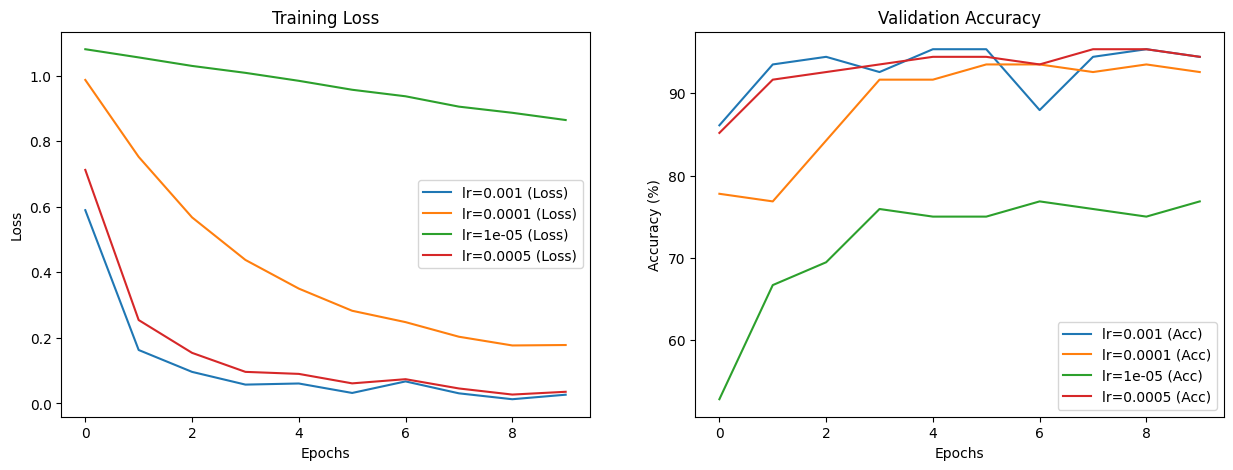

In [138]:
model = get_fresh_resnet()
exp_high_medium_lr = ResNetExperiment(model, train_loader, val_loader)
exp_high_medium_lr.run(epochs=10, lr=5e-4)
experiments[f"lr={5e-4}"] = exp_high_medium_lr.history

plot_experiment_results(experiments.values(), experiments.keys())

## Experiment 2: Data augmentation effect

--- Running Experiment: Frozen Backbone ---
Epoch 1/10 - Loss: 0.7122, Val Acc: 85.19%
Epoch 2/10 - Loss: 0.2543, Val Acc: 91.67%
Epoch 3/10 - Loss: 0.1542, Val Acc: 92.59%
Epoch 4/10 - Loss: 0.0962, Val Acc: 93.52%
Epoch 5/10 - Loss: 0.0900, Val Acc: 94.44%
Epoch 6/10 - Loss: 0.0611, Val Acc: 94.44%
Epoch 7/10 - Loss: 0.0738, Val Acc: 93.52%
Epoch 8/10 - Loss: 0.0455, Val Acc: 95.37%
Epoch 9/10 - Loss: 0.0269, Val Acc: 95.37%
Epoch 10/10 - Loss: 0.0354, Val Acc: 94.44%
--- Running Experiment: Frozen Backbone ---
Epoch 1/10 - Loss: 0.7516, Val Acc: 88.89%
Epoch 2/10 - Loss: 0.3613, Val Acc: 93.52%
Epoch 3/10 - Loss: 0.1922, Val Acc: 93.52%
Epoch 4/10 - Loss: 0.1457, Val Acc: 92.59%
Epoch 5/10 - Loss: 0.1300, Val Acc: 91.67%
Epoch 6/10 - Loss: 0.0950, Val Acc: 92.59%
Epoch 7/10 - Loss: 0.0770, Val Acc: 92.59%
Epoch 8/10 - Loss: 0.0872, Val Acc: 92.59%
Epoch 9/10 - Loss: 0.0661, Val Acc: 91.67%
Epoch 10/10 - Loss: 0.0485, Val Acc: 92.59%


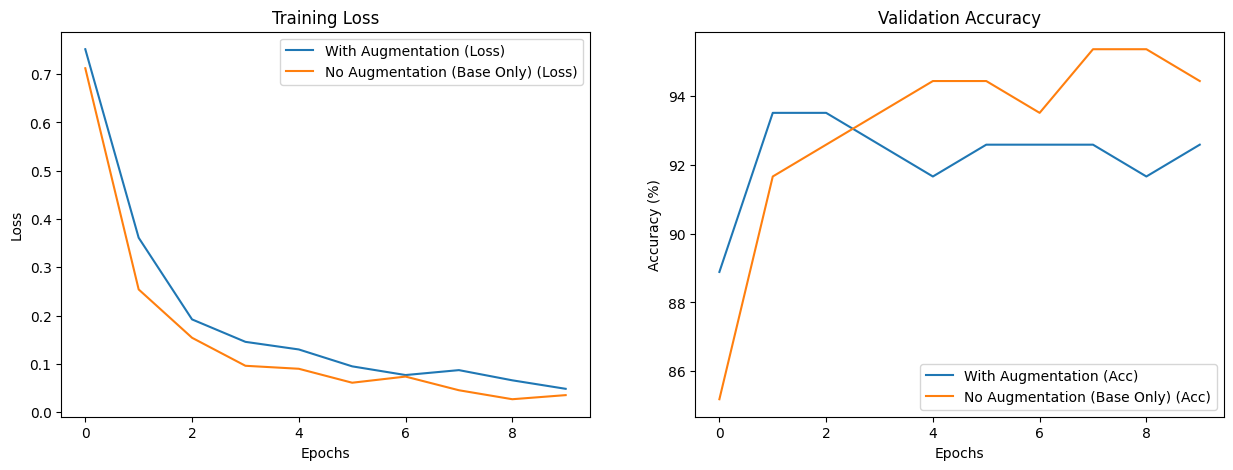

In [9]:
# No Augmentation
model_no_aug = get_fresh_resnet()
train_loader_no_aug, val_loader = get_loaders(use_augmentation=False)
exp_no_aug = ResNetExperiment(model_no_aug, train_loader_no_aug, val_loader)
exp_no_aug.run(epochs=10, lr=5e-4)

# With Augmentation
model_aug = get_fresh_resnet()
train_loader_aug, val_loader = get_loaders(use_augmentation=True)
exp_aug = ResNetExperiment(model_aug, train_loader_aug, val_loader)
exp_aug.run(epochs=10, lr=5e-4)

# Plot Comparison
plot_experiment_results(
    [exp_aug.history, exp_no_aug.history],
    ['With Augmentation', 'No Augmentation (Base Only)']
)

## Experiment 3: Freezing vs Unfreezing strategy


--- Training Model A: 20 Epochs Frozen (Control) ---
--- Running Experiment: Frozen Backbone ---
Epoch 1/20 - Loss: 1.0070, Val Acc: 72.22%
Epoch 2/20 - Loss: 0.8127, Val Acc: 75.00%
Epoch 3/20 - Loss: 0.6550, Val Acc: 79.63%
Epoch 4/20 - Loss: 0.5351, Val Acc: 87.96%
Epoch 5/20 - Loss: 0.4375, Val Acc: 90.74%
Epoch 6/20 - Loss: 0.3594, Val Acc: 88.89%
Epoch 7/20 - Loss: 0.3079, Val Acc: 92.59%
Epoch 8/20 - Loss: 0.2848, Val Acc: 91.67%
Epoch 9/20 - Loss: 0.2452, Val Acc: 92.59%
Epoch 10/20 - Loss: 0.2250, Val Acc: 91.67%
Epoch 11/20 - Loss: 0.2073, Val Acc: 93.52%
Epoch 12/20 - Loss: 0.2080, Val Acc: 91.67%
Epoch 13/20 - Loss: 0.1760, Val Acc: 93.52%
Epoch 14/20 - Loss: 0.1567, Val Acc: 93.52%
Epoch 15/20 - Loss: 0.1517, Val Acc: 94.44%
Epoch 16/20 - Loss: 0.1469, Val Acc: 94.44%
Epoch 17/20 - Loss: 0.1398, Val Acc: 94.44%
Epoch 18/20 - Loss: 0.1395, Val Acc: 91.67%
Epoch 19/20 - Loss: 0.1225, Val Acc: 95.37%
Epoch 20/20 - Loss: 0.1170, Val Acc: 91.67%

--- Training Model B: Phase 1 

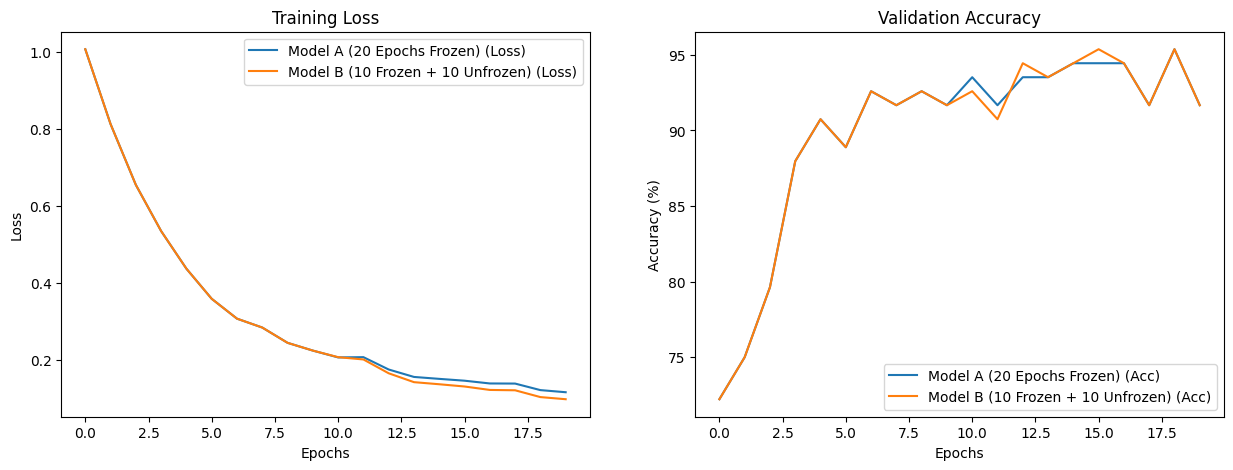

In [134]:
# 1. Setup the data (using your best augmentation settings from Experiment 2)
train_loader, val_loader = get_loaders(use_augmentation=True)

# --- MODEL A: The "Long Frozen" Control (20 Epochs Frozen) ---
# This tests the maximum potential of just the head with more time.
print("\n--- Training Model A: 20 Epochs Frozen (Control) ---")
model_a = get_fresh_resnet()
exp_control = ResNetExperiment(model_a, train_loader, val_loader)
exp_control.run(epochs=20, lr=1e-4, unfreeze_layer4=False)

# --- MODEL B: The Fine-Tuning Strategy (10 Frozen + 10 Unfrozen) ---
# This tests the benefit of specializing the backbone.
print("\n--- Training Model B: Phase 1 (10 Epochs Frozen) ---")
model_b = get_fresh_resnet()
exp_b_phase1 = ResNetExperiment(model_b, train_loader, val_loader)
exp_b_phase1.run(epochs=10, lr=1e-4, unfreeze_layer4=False)

print("\n--- Training Model B: Phase 2 (10 Epochs Unfrozen/Fine-Tuning) ---")
# Unfreeze layer4 specifically for the second half
for param in model_b.layer4.parameters():
    param.requires_grad = True

exp_b_phase2 = ResNetExperiment(model_b, train_loader, val_loader)
exp_b_phase2.run(epochs=10, lr=1e-4, unfreeze_layer4=True)

# 2. Prepare combined history for Model B to plot it as a single 20-epoch line
model_b_full_history = {
    'train_loss': exp_b_phase1.history['train_loss'] + exp_b_phase2.history['train_loss'],
    'val_acc': exp_b_phase1.history['val_acc'] + exp_b_phase2.history['val_acc']
}

# 3. Plot the results
plot_experiment_results(
    [exp_control.history, model_b_full_history],
    ['Model A (20 Epochs Frozen)', 'Model B (10 Frozen + 10 Unfrozen)']
)